## **MODELING AND FORECASTING DESERTIFICATION IN THE ABSHERON PENINSULA USING SATELLITE IMAGERY AND TIME SERIES ANALYSIS**

---



# Import libraries

In [5]:

import ee
import geemap
import folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
from folium import plugins
import geopy
from geopy.geocoders import Nominatim
from PIL import Image
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import linregress
from statsmodels.tsa.arima.model import ARIMA
from branca.colormap import LinearColormap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb
from datetime import datetime
import plotly.express as px
from plotly.subplots import make_subplots
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from scipy.interpolate import make_interp_spline

# Create Setup

In [6]:

try:
    ee.Initialize(project='ee-eoc') # change this your project name
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project='ee-eoc') # change this your project name

In [15]:
# Define the Area of Interest (AOI) - Absheron peninsula
aoi = ee.Geometry.Polygon([
    [50.4, 40.7],
    [49.5, 40.7],
    [49.5, 40.2],
    [50.4, 40.2],
    [50.4, 40.7]
])

In [16]:
#Visualize AOI

def create_enhanced_map():

    center = aoi.centroid().getInfo()['coordinates']
    m = folium.Map(location=[center[1], center[0]], zoom_start=10, tiles="cartodb positron")
    folium.GeoJson(
        aoi.getInfo(),
        name="Area of Interest",
        style_function=lambda x: {'fillColor': '#ff7800', 'color': '#000000', 'fillOpacity': 0.3, 'weight': 2}
    ).add_to(m)

    coordinates = aoi.coordinates().getInfo()[0]
    for i, coord in enumerate(coordinates[:-1]):
        folium.Marker(
            location=[coord[1], coord[0]],
            popup=f"Vertex {i+1}<br>Lat: {coord[1]:.2f}, Lon: {coord[0]:.2f}",
            icon=folium.Icon(color='green', icon='info-sign')
        ).add_to(m)
    minimap = plugins.MiniMap()
    m.add_child(minimap)
    plugins.Fullscreen().add_to(m)
    plugins.MeasureControl(position='topright', primary_length_unit='kilometers').add_to(m)
    folium.LayerControl().add_to(m)

    title_html = '''
             <h3 align="center" style="font-size:16px"><b>Research Project: Area of Interest Visualization</b></h3>
             '''
    m.get_root().html.add_child(folium.Element(title_html))
    return m

m = create_enhanced_map()
display(m)
area_sq_km = aoi.area().getInfo() / 1e6
center = aoi.centroid().getInfo()['coordinates']

print(f"AOI Info:")
print(f"- Total Area: {area_sq_km:.2f} sq km")
print(f"- Center Coordinates: Lat {center[1]:.2f}, Lon {center[0]:.2f}")
print(f"- Location: Absheron Peninsula")

AOI Info:
- Total Area: 4233.98 sq km
- Center Coordinates: Lat 40.45, Lon 49.95
- Location: Absheron Peninsula


In [17]:
# Define the time range for analysis
start_date = '2013-01-01'
end_date = '2024-07-31'


# NDVI, ALBEDO, LST, NDWI TIME SERIES



<ipython-input-18-06679f585061>:144: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
<ipython-input-18-06679f585061>:144: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
<ipython-input-18-06679f585061>:144: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn 

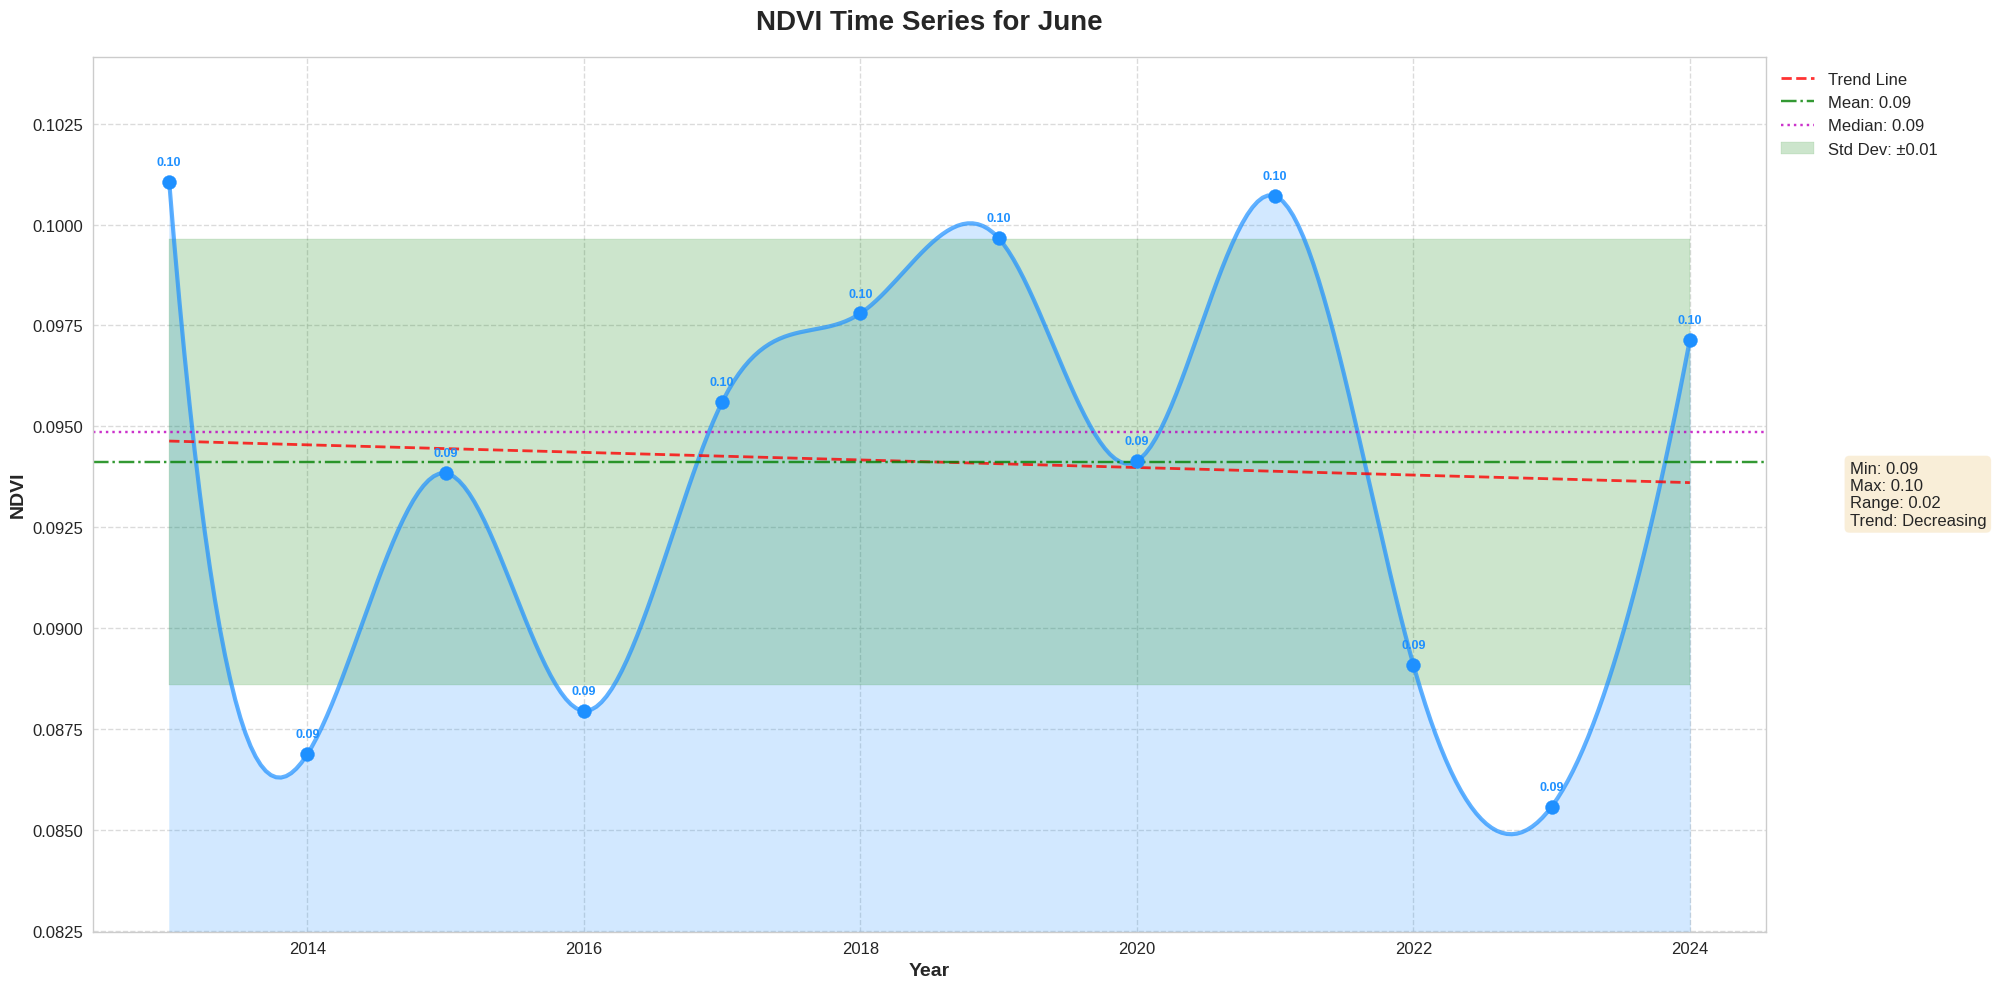

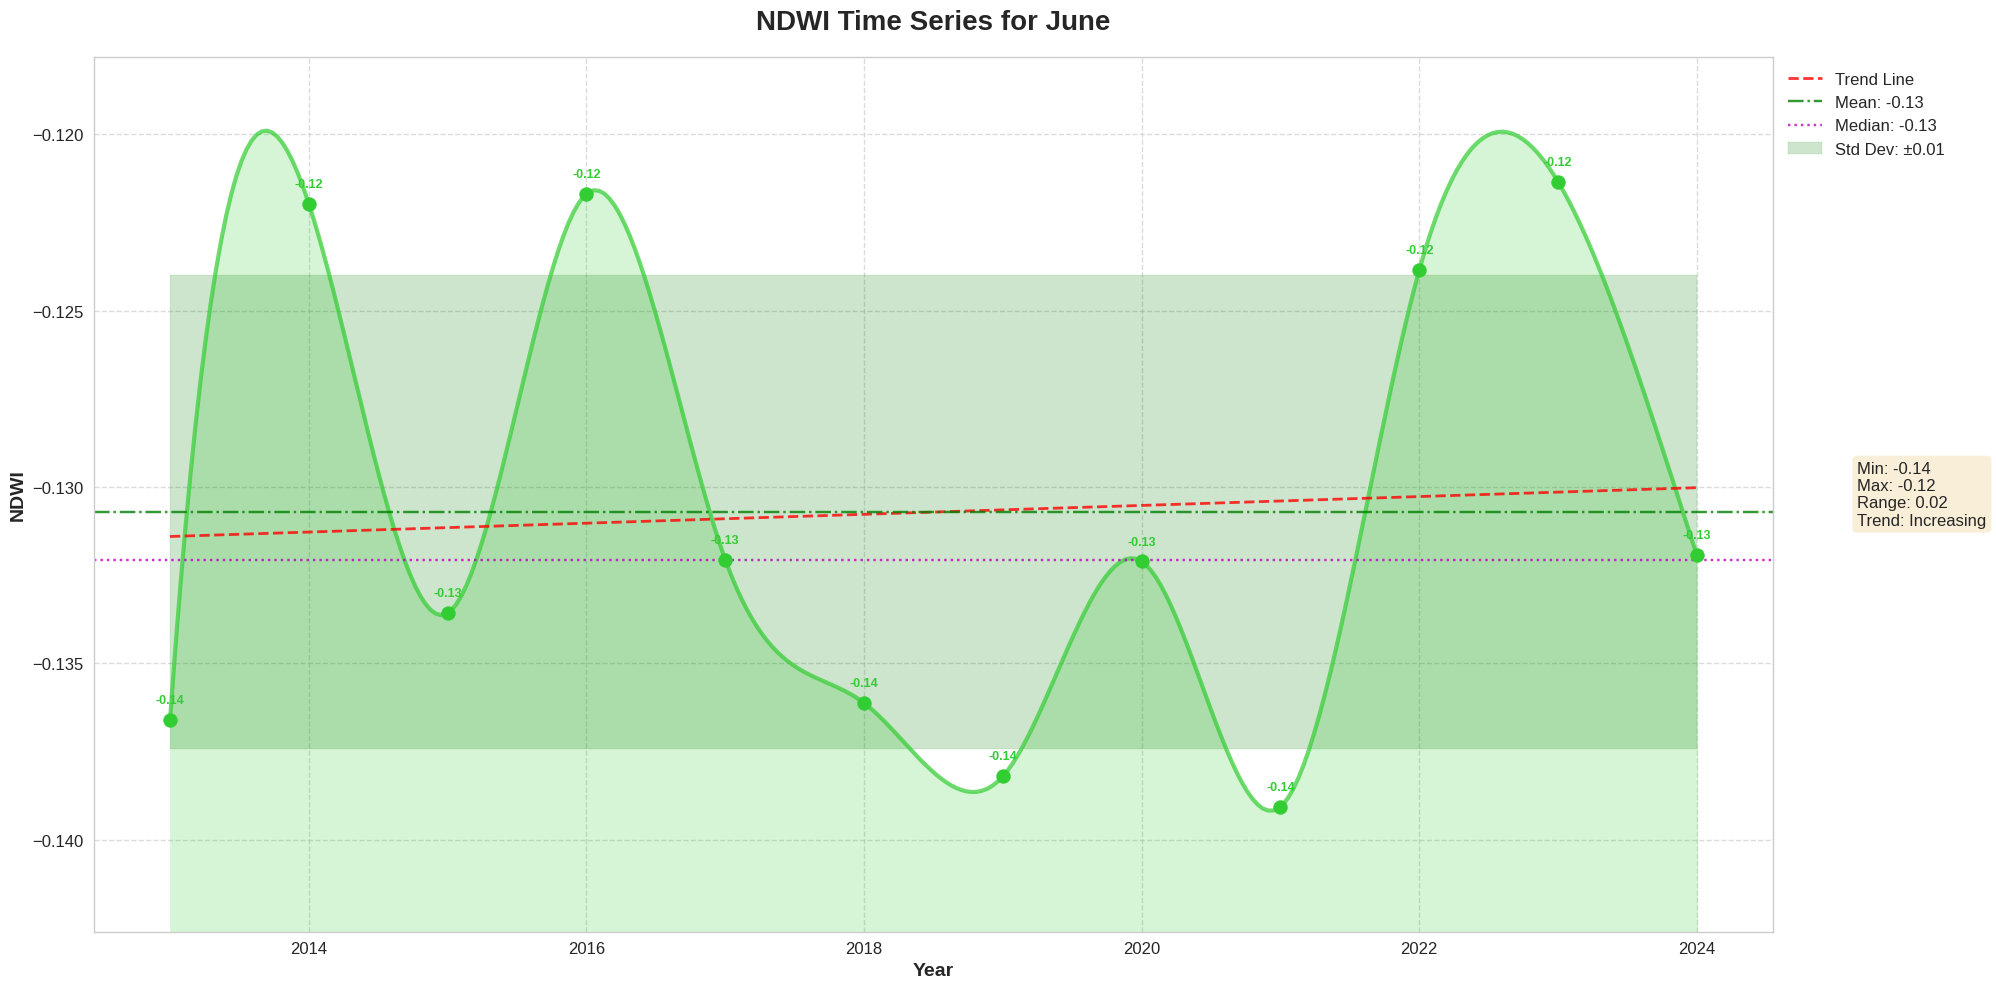

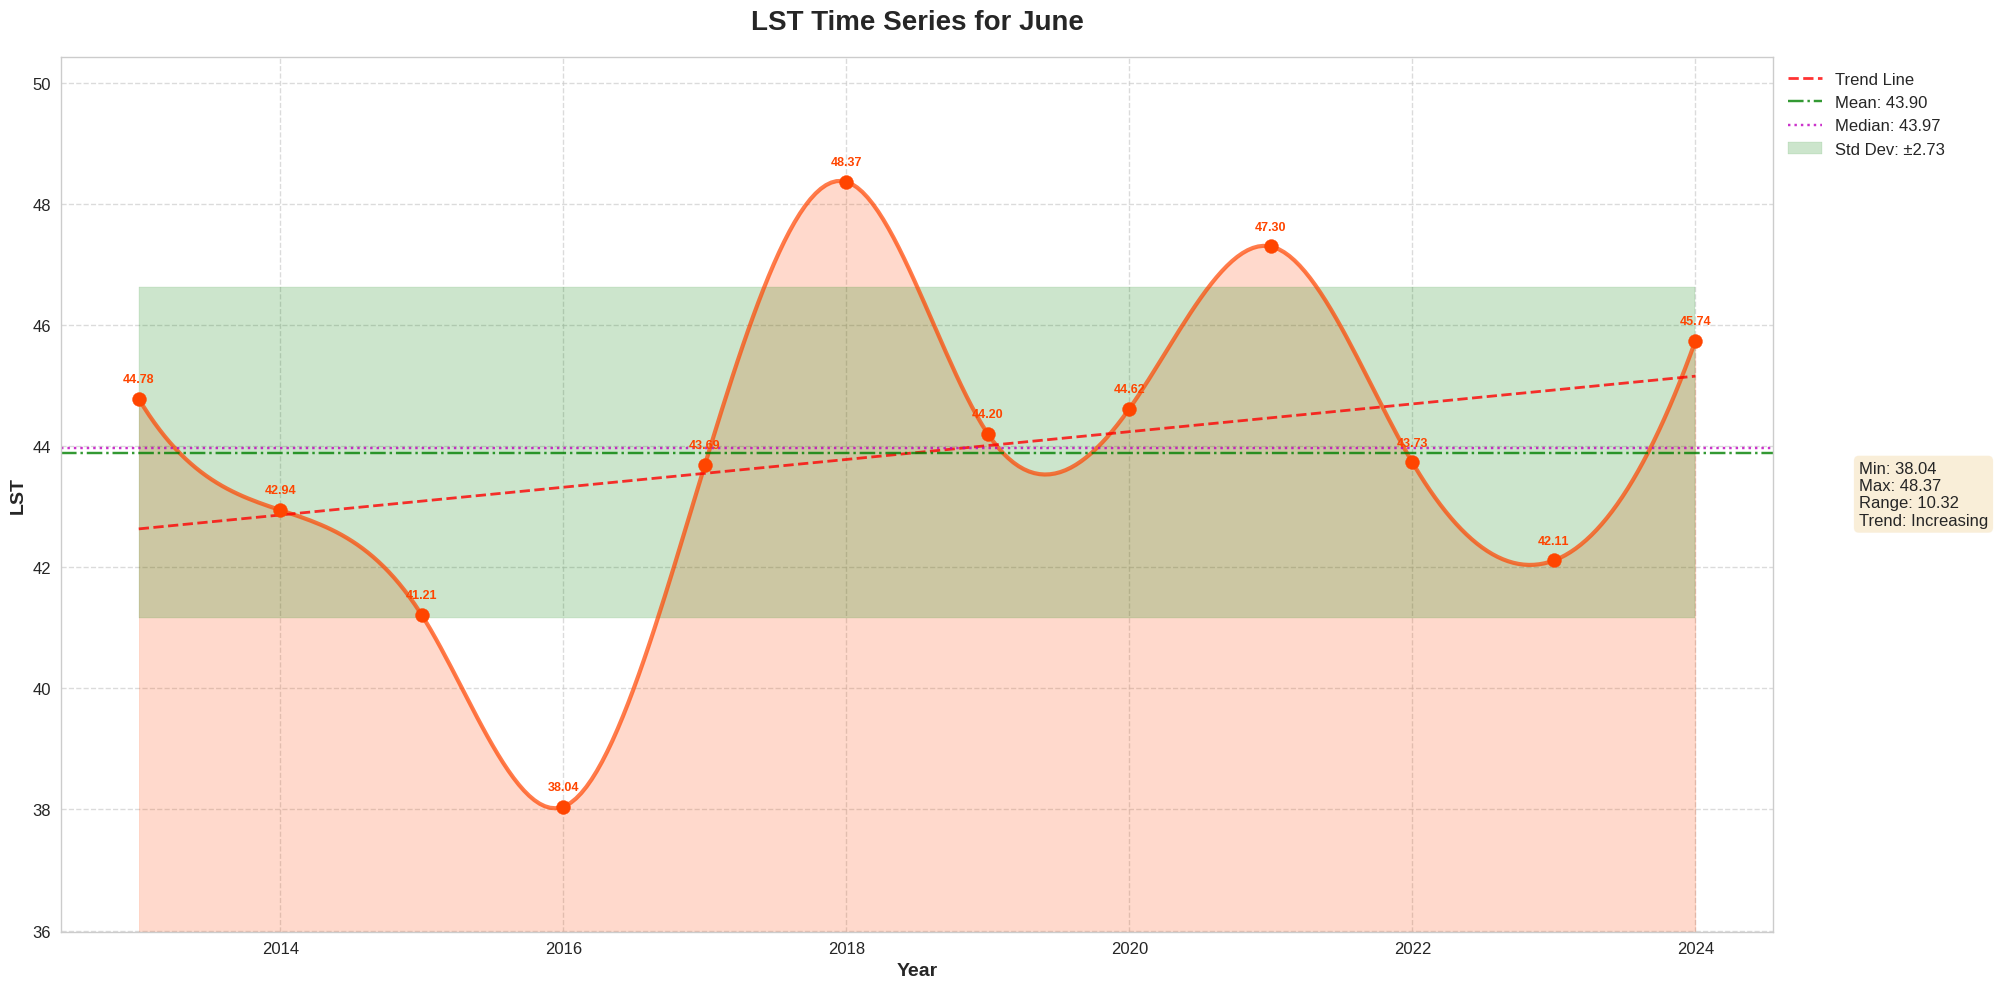

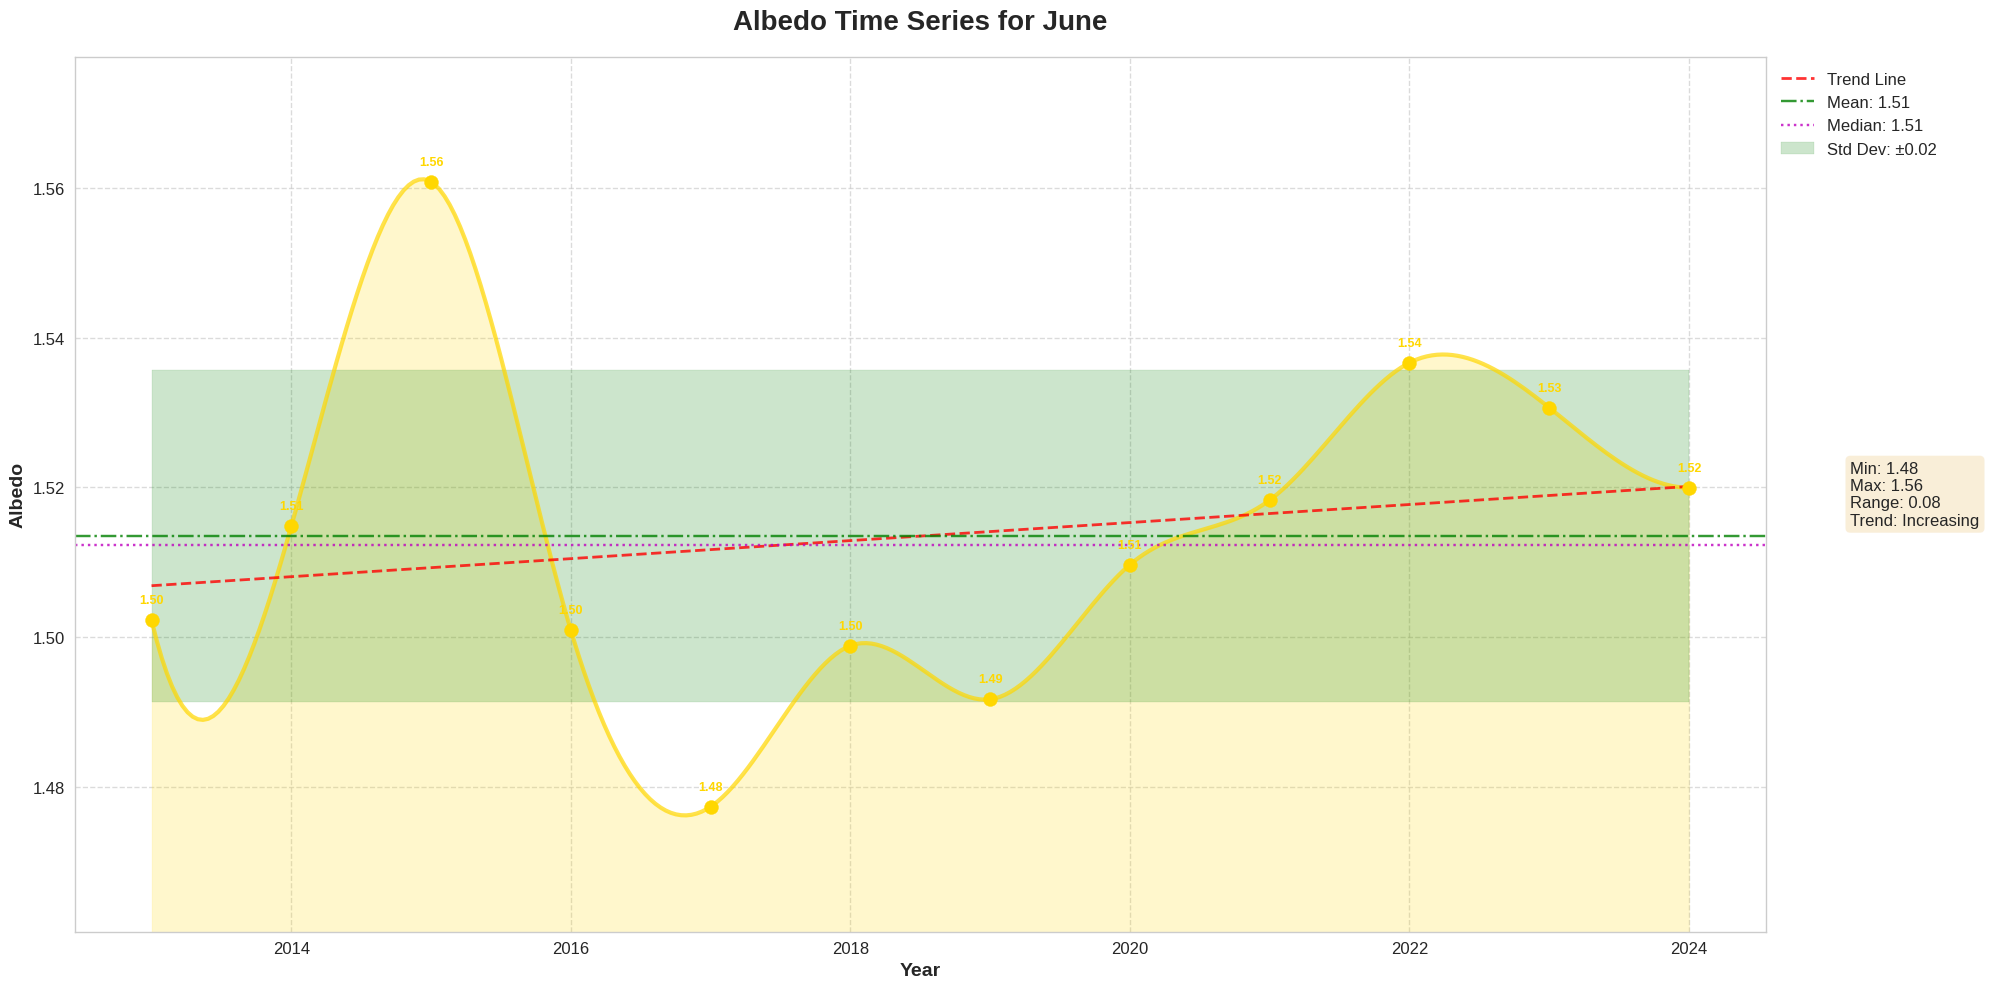

In [ ]:

def create_land_mask(aoi):
    # Use ESA WorldCover dataset to create a land mask
    worldcover = ee.ImageCollection("ESA/WorldCover/v100").first()
    land_cover = worldcover.select('Map')

    # Create a mask where land cover classes are not water (class 80)
    land_mask = land_cover.neq(80)

    return land_mask

def maskL8sr(image):
    cloudShadowBitMask = 1 << 3
    cloudsBitMask = 1 << 5
    qa = image.select('QA_PIXEL')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
           qa.bitwiseAnd(cloudsBitMask).eq(0))
    return image.updateMask(mask)

def addNDVI(image):
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    return image.addBands(ndvi)

def addNDWI(image):
    ndwi = image.normalizedDifference(['SR_B3', 'SR_B5']).rename('NDWI')
    return image.addBands(ndwi)

def addLST(image):
    b10 = image.select('ST_B10').multiply(0.00341802).add(149.0).subtract(273.15)
    return image.addBands(b10.rename('LST'))

def addAlbedo(image):
    albedo = image.expression(
        '((B2 * 0.3) + (B4 * 0.3) + (B5 * 0.3) + (B6 * 0.1)) * 0.0001',
        {
            'B2': image.select('SR_B2'),
            'B4': image.select('SR_B4'),
            'B5': image.select('SR_B5'),
            'B6': image.select('SR_B6')
        }
    ).rename('Albedo')
    return image.addBands(albedo)

def handle_anomaly(df, column, year, nearby_months, aoi, addFunction, land_mask):
    nearby_values = []
    for m in nearby_months:
        start_date = ee.Date.fromYMD(year, m, 1)
        end_date = start_date.advance(1, 'month')
        l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
            .filterBounds(aoi) \
            .filterDate(start_date, end_date) \
            .map(maskL8sr) \
            .map(addFunction) \
            .map(lambda img: img.updateMask(land_mask))  # Apply land mask

        mean_value = l8.select(column).mean()
        value = mean_value.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=aoi,
            scale=30,
            maxPixels=1e9
        ).get(column)
        nearby_values.append(ee.Number(value).getInfo())

    mean_value = np.mean([v for v in nearby_values if v is not None])
    df.loc[df['Year'] == year, column] = mean_value

    return df

def create_time_series(aoi, start_year, end_year, month, parameters, collection='LANDSAT/LC08/C02/T1_L2'):
    years = list(range(start_year, end_year + 1))
    land_mask = create_land_mask(aoi)

    # Color palette for different parameters
    color_palette = {
        'NDVI': '#1e90ff',
        'NDWI': '#32cd32',
        'LST': '#ff4500',
        'Albedo': '#ffd700'
    }

    for param, addFunction in parameters.items():
        values = []
        for year in years:
            start_date = ee.Date.fromYMD(year, month, 1)
            end_date = start_date.advance(1, 'month')

            l8 = ee.ImageCollection(collection) \
                .filterBounds(aoi) \
                .filterDate(start_date, end_date) \
                .map(maskL8sr) \
                .map(addFunction) \
                .map(lambda img: img.updateMask(land_mask))

            mean_value = l8.select(param).mean()

            value = mean_value.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=aoi,
                scale=30,
                maxPixels=1e9
            ).get(param)

            values.append(ee.Number(value))

        value_list = ee.List(values).getInfo()
        df = pd.DataFrame({'Year': years, param: value_list})

        # Handle anomaly for 2014
        if 2014 in years:
            nearby_months = [5, 7]
            df = handle_anomaly(df, param, 2014, nearby_months, aoi, addFunction, land_mask)

        plot_parameter(df, param, month, color_palette[param])

    plt.tight_layout()
    plt.show()

def plot_parameter(df, column, month, color):
    plt.figure(figsize=(20, 10))

    # Create smooth line
    x_smooth = np.linspace(df['Year'].min(), df['Year'].max(), 300)
    spl = make_interp_spline(df['Year'], df[column], k=3)
    y_smooth = spl(x_smooth)

    # Plot smooth line
    plt.plot(x_smooth, y_smooth, linestyle='-', linewidth=3, color=color, alpha=0.7)

    # Plot original points
    scatter = plt.scatter(df['Year'], df[column], marker='o', s=100, color=color, zorder=5)

    # Add value labels to points
    for i, txt in enumerate(df[column]):
        plt.annotate(f'{txt:.2f}', (df['Year'].iloc[i], df[column].iloc[i]),
                     xytext=(0, 10), textcoords='offset points', ha='center', va='bottom',
                     fontsize=9, fontweight='bold', color=color)

    plt.title(f'{column} Time Series for {ee.Date.fromYMD(1, month, 1).format("MMMM").getInfo()}',
              fontsize=20, fontweight='bold', pad=20)
    plt.xlabel('Year', fontsize=14, fontweight='bold')
    plt.ylabel(column, fontsize=14, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.style.use('seaborn-whitegrid')
    plt.tick_params(axis='both', which='major', labelsize=12)

    # Adjust y-axis range with increased margin
    y_min, y_max = df[column].min(), df[column].max()
    y_range = y_max - y_min
    plt.ylim(y_min - 0.2 * y_range, y_max + 0.2 * y_range)

    # Fill below the line
    plt.fill_between(x_smooth, y_smooth, min(plt.ylim()), alpha=0.2, color=color)

    # Add trend line
    z = np.polyfit(df['Year'], df[column], 1)
    p = np.poly1d(z)
    plt.plot(df['Year'], p(df['Year']), "r--", alpha=0.8, linewidth=2, label="Trend Line")

    # Add horizontal lines for mean and median
    mean_value = df[column].mean()
    median_value = df[column].median()
    plt.axhline(y=mean_value, color='g', linestyle='-.', alpha=0.8, label=f'Mean: {mean_value:.2f}')
    plt.axhline(y=median_value, color='m', linestyle=':', alpha=0.8, label=f'Median: {median_value:.2f}')

    # Add shaded area for standard deviation
    std_dev = df[column].std()
    plt.fill_between(df['Year'], mean_value - std_dev, mean_value + std_dev,
                     alpha=0.2, color='g', label=f'Std Dev: ±{std_dev:.2f}')

    # Enhance legend
    plt.legend(loc='upper left', fontsize=12, bbox_to_anchor=(1, 1))

    # Add text box with statistics
    stats_text = f"Min: {df[column].min():.2f}\nMax: {df[column].max():.2f}\n"
    stats_text += f"Range: {df[column].max() - df[column].min():.2f}\n"
    stats_text += f"Trend: {'Increasing' if z[0] > 0 else 'Decreasing'}"
    plt.text(1.05, 0.5, stats_text, transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()

# Example usage
start_year = 2013
end_year = 2024
month = 6  # June

parameters = {
    'NDVI': addNDVI,
    'NDWI': addNDWI,
    'LST': addLST,
    'Albedo': addAlbedo
}

create_time_series(aoi, start_year, end_year, month, parameters)



# NDVI MAP

In [ ]:
import ee
import geemap
import ipywidgets as widgets
from IPython.display import display

# Initialize Earth Engine
ee.Initialize()

def create_ndvi_map(aoi, start_year, end_year, month):
    def create_land_mask(aoi):
        worldcover = ee.ImageCollection("ESA/WorldCover/v100").first()
        land_cover = worldcover.select('Map')
        land_mask = land_cover.neq(80)
        return land_mask

    def maskL8sr(image):
        cloudShadowBitMask = 1 << 3
        cloudsBitMask = 1 << 5
        qa = image.select('QA_PIXEL')
        mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
               qa.bitwiseAnd(cloudsBitMask).eq(0))
        return image.updateMask(mask)

    def addNDVI(image):
        ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
        return image.addBands(ndvi)

    land_mask = create_land_mask(aoi)

    # Create a list to store annual NDVI images
    ndvi_list = []

    for year in range(start_year, end_year + 1):
        start_date = ee.Date.fromYMD(year, month, 1)
        end_date = start_date.advance(1, 'month')

        l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
            .filterBounds(aoi) \
            .filterDate(start_date, end_date) \
            .map(maskL8sr) \
            .map(addNDVI) \
            .map(lambda img: img.updateMask(land_mask))

        annual_ndvi = l8.select('NDVI').mean().set('year', year)
        ndvi_list.append(annual_ndvi)

    # Convert the list to an ImageCollection
    ndvi_collection = ee.ImageCollection(ndvi_list)

    # Calculate the NDVI trend
    def calculate_trend(ic):
        def addTime(image):
            return image.addBands(image.metadata('year').subtract(start_year).rename('t'))

        withTime = ic.map(addTime)
        trend = withTime.select(['t', 'NDVI']).reduce(ee.Reducer.linearFit())

        return trend.select('scale').rename('NDVI_trend')

    ndvi_trend = calculate_trend(ndvi_collection)

    # Create the map
    map_center = aoi.centroid().getInfo()['coordinates']
    m = geemap.Map(center=[map_center[1], map_center[0]], zoom=8)

    # Add the NDVI trend layer
    vis_params = {
        'min': -0.01,
        'max': 0.01,
        'palette': ['red', 'yellow', 'green']
    }
    m.addLayer(ndvi_trend, vis_params, 'NDVI Trend')

    # Add a color legend
    m.add_colorbar(vis_params, label='NDVI Trend (per year)')


    # Display the map
    display(m)

    # Add widgets for interactivity
    year_slider = widgets.IntRangeSlider(
        value=[start_year, end_year],
        min=start_year,
        max=end_year,
        step=1,
        description='Year Range:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True
    )

    month_dropdown = widgets.Dropdown(
        options=[(ee.Date.fromYMD(1, i, 1).format('MMMM').getInfo(), i) for i in range(1, 13)],
        value=month,
        description='Month:',
    )

    def update_map(change):
        new_start_year, new_end_year = year_slider.value
        new_month = month_dropdown.value
        create_ndvi_map(aoi, new_start_year, new_end_year, new_month)

    year_slider.observe(update_map, names='value')
    month_dropdown.observe(update_map, names='value')

    display(widgets.VBox([year_slider, month_dropdown]))

# Example usage

create_ndvi_map(aoi, 2013, 2024, 6)

Map(center=[40.45056242724613, 49.9499999999999], controls=(WidgetControl(options=['position', 'transparent_bg…

Map(center=[40.45056242724613, 49.9499999999999], controls=(WidgetControl(options=['position', 'transparent_bg…

Map(center=[40.45056242724613, 49.9499999999999], controls=(WidgetControl(options=['position', 'transparent_bg…

# NDVI MAP COMPARISON (2013 - 2024)

In [ ]:
import ee
import geemap
import ipywidgets as widgets
from IPython.display import display

# Initialize Earth Engine
ee.Initialize()

def create_comparative_ndvi_maps(aoi, start_year, end_year, month):
    def create_land_mask(aoi):
        worldcover = ee.ImageCollection("ESA/WorldCover/v100").first()
        land_cover = worldcover.select('Map')
        land_mask = land_cover.neq(80)
        return land_mask

    def maskL8sr(image):
        cloudShadowBitMask = 1 << 3
        cloudsBitMask = 1 << 5
        qa = image.select('QA_PIXEL')
        mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
               qa.bitwiseAnd(cloudsBitMask).eq(0))
        return image.updateMask(mask)

    def addNDVI(image):
        ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
        return image.addBands(ndvi)

    land_mask = create_land_mask(aoi)

    def get_ndvi_for_year(year):
        start_date = ee.Date.fromYMD(year, month, 1)
        end_date = start_date.advance(1, 'month')

        l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
            .filterBounds(aoi) \
            .filterDate(start_date, end_date) \
            .map(maskL8sr) \
            .map(addNDVI) \
            .map(lambda img: img.updateMask(land_mask))

        return l8.select('NDVI').mean()

    ndvi_2013 = get_ndvi_for_year(start_year)
    ndvi_2024 = get_ndvi_for_year(end_year)

    # Create the maps
    map_center = aoi.centroid().getInfo()['coordinates']
    m1 = geemap.Map(center=[map_center[1], map_center[0]], zoom=8)
    m2 = geemap.Map(center=[map_center[1], map_center[0]], zoom=8)

    # Add the NDVI layers
    vis_params = {
        'min': 0,
        'max': 1,
        'palette': ['red', 'yellow', 'green']
    }
    m1.addLayer(ndvi_2013, vis_params, f'NDVI {start_year}')
    m2.addLayer(ndvi_2024, vis_params, f'NDVI {end_year}')

    # Add color legends
    m1.add_colorbar(vis_params, label=f'NDVI {start_year}')
    m2.add_colorbar(vis_params, label=f'NDVI {end_year}')



    # Display the maps side by side
    display(widgets.HBox([m1, m2]))

    # Add widget for month selection
    month_dropdown = widgets.Dropdown(
        options=[(ee.Date.fromYMD(1, i, 1).format('MMMM').getInfo(), i) for i in range(1, 13)],
        value=month,
        description='Month:',
    )

    def update_maps(change):
        new_month = month_dropdown.value
        create_comparative_ndvi_maps(aoi, start_year, end_year, new_month)

    month_dropdown.observe(update_maps, names='value')

    display(month_dropdown)

# Example usage

create_comparative_ndvi_maps(aoi, 2013, 2024, 6)

Dropdown(description='Month:', index=5, options=(('January', 1), ('February', 2), ('March', 3), ('April', 4), …

# NDVI ANALYSIS FOR EVERY MONTH SINCE 2013

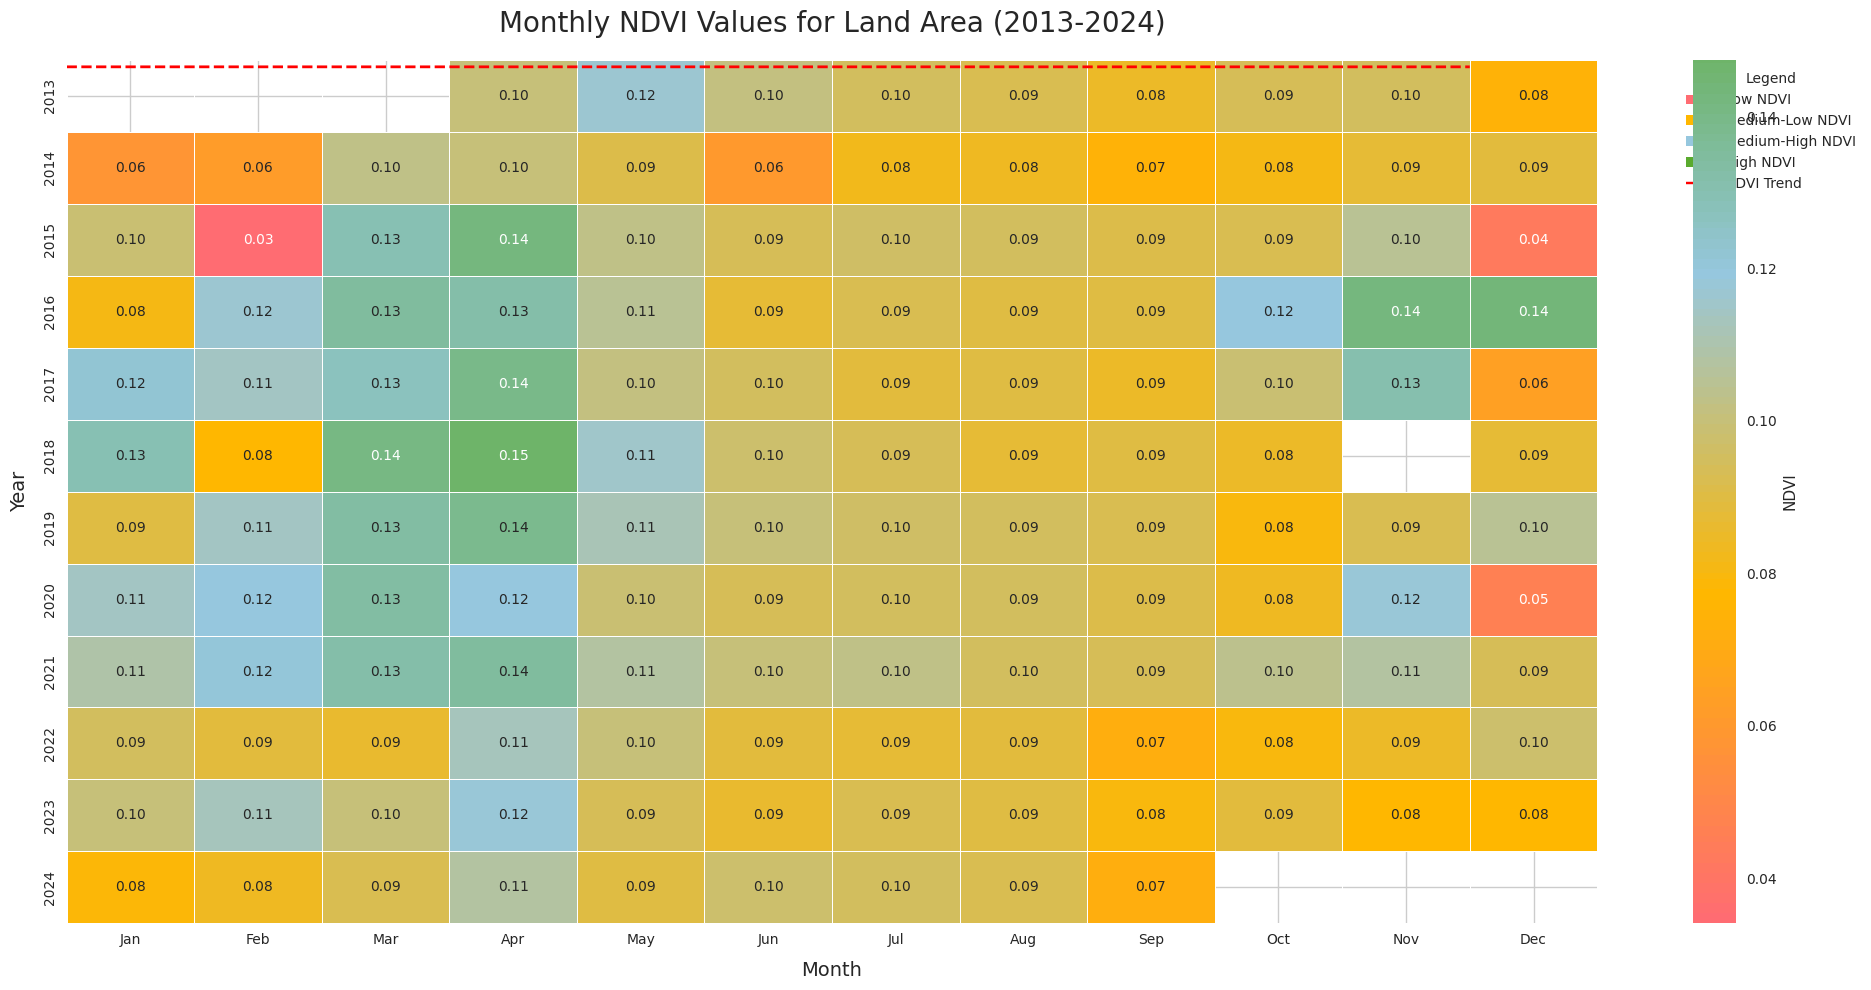

<ipython-input-19-0249dcf1d9ba>:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Month', y='NDVI', data=df, palette=colors)
<ipython-input-19-0249dcf1d9ba>:133: UserWarning: 
The palette list has fewer values (4) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x='Month', y='NDVI', data=df, palette=colors)


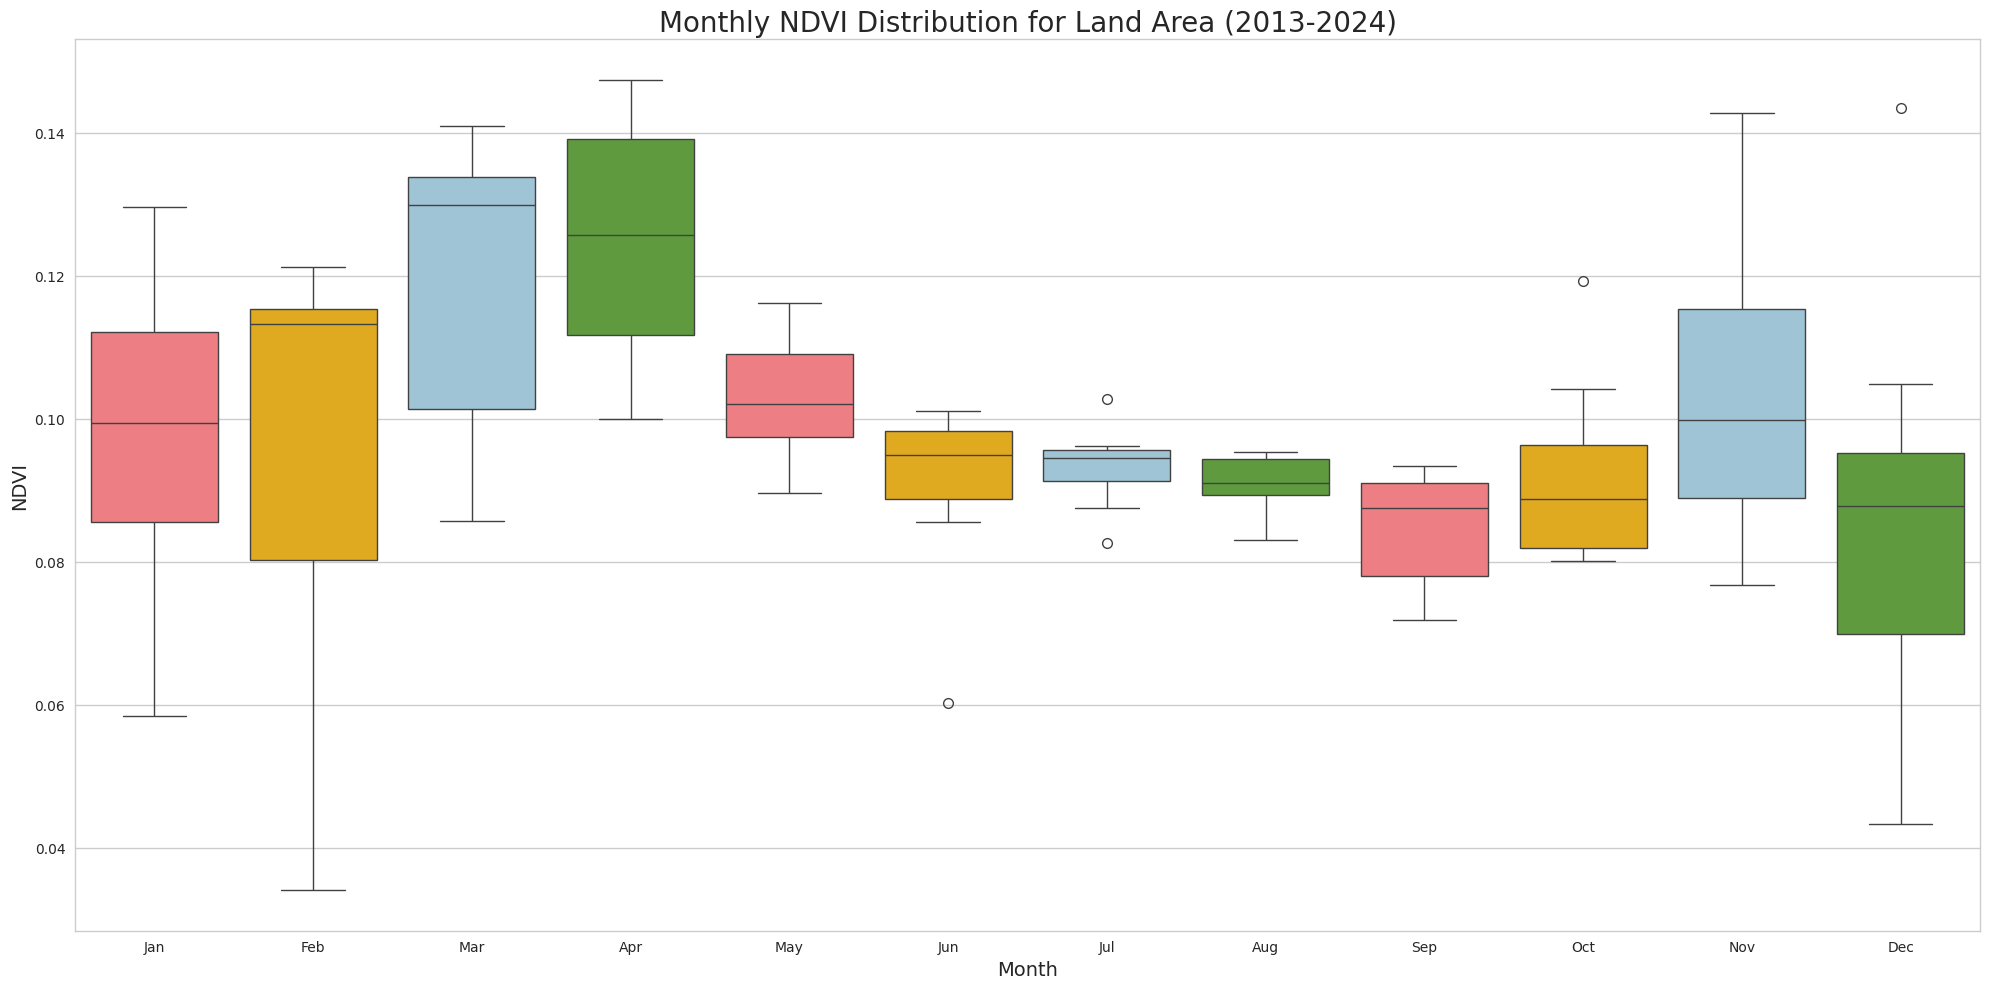

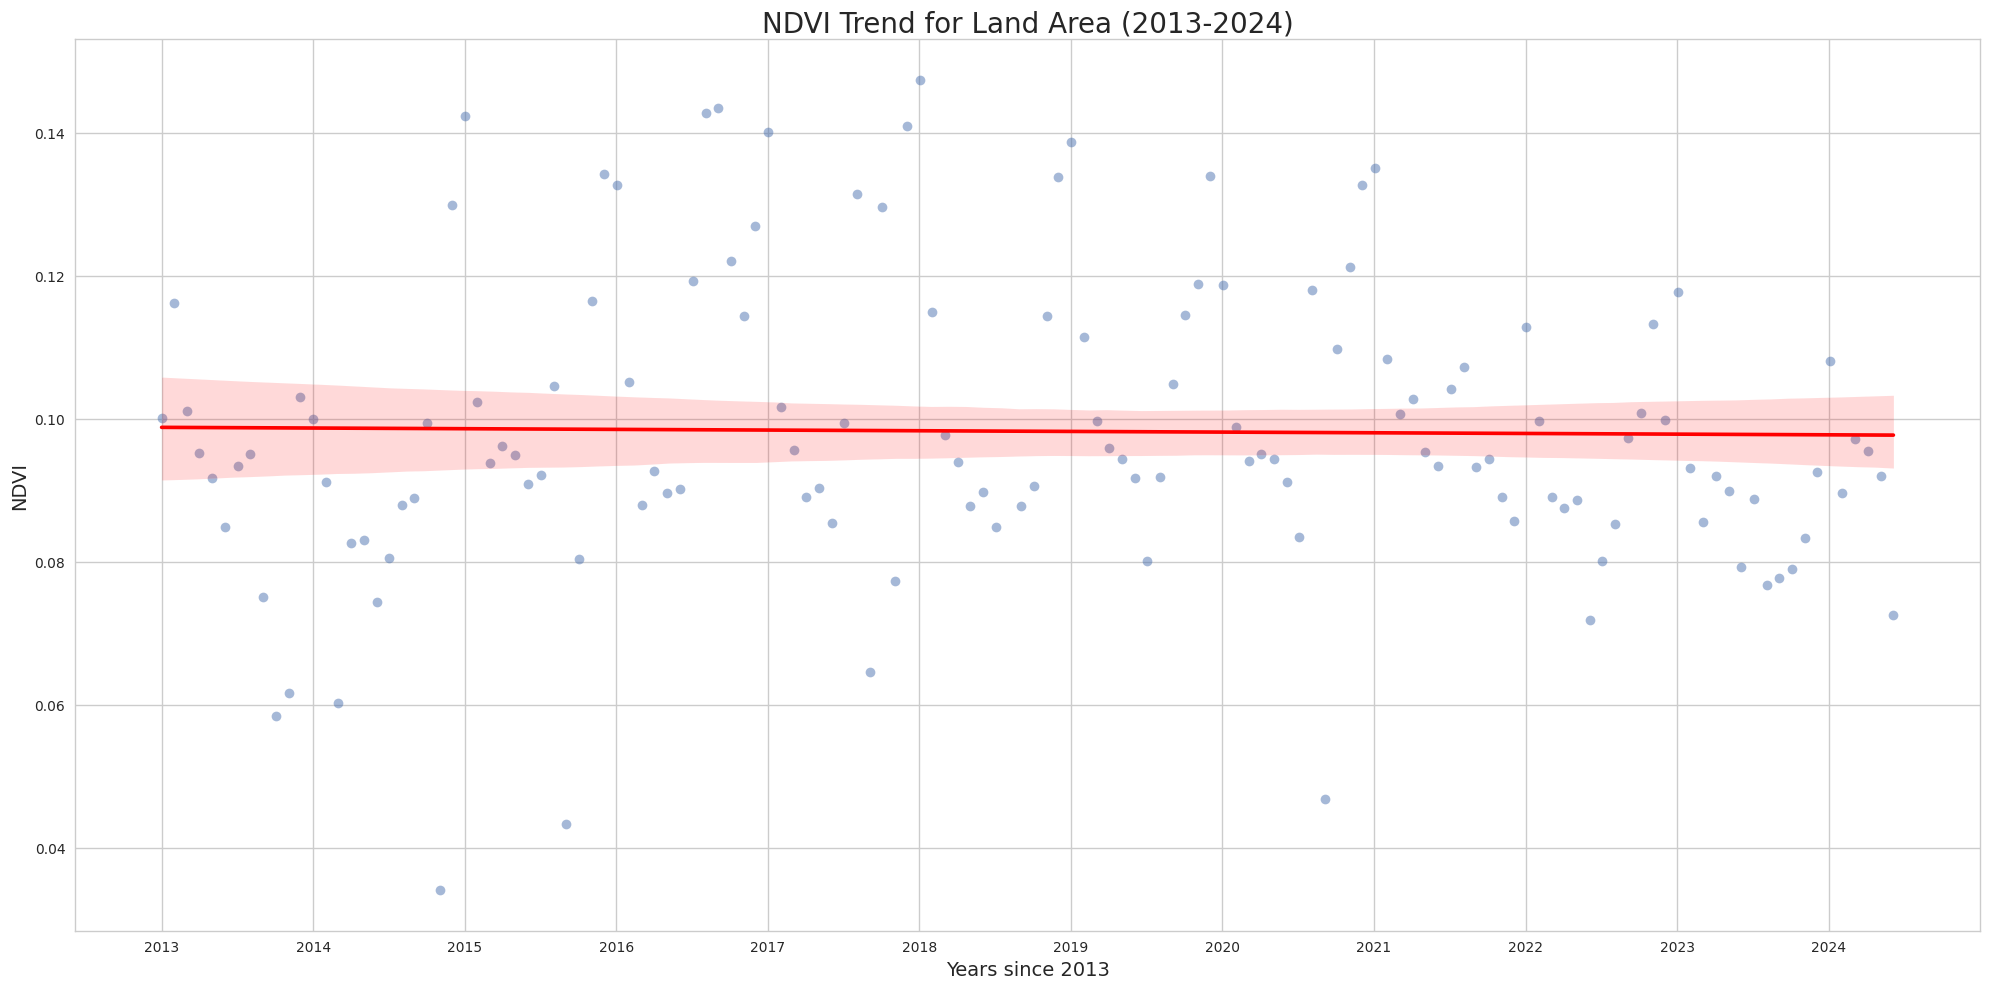

       count      mean       std       min       25%       50%       75%  \
Month                                                                      
1       11.0  0.098087  0.020765  0.058368  0.085529  0.099450  0.112112   
2       11.0  0.094886  0.028471  0.034076  0.080272  0.113322  0.115394   
3       11.0  0.119401  0.019893  0.085645  0.101395  0.129934  0.133872   
4       12.0  0.124494  0.016904  0.099983  0.111673  0.125727  0.139093   
5       12.0  0.102698  0.008881  0.089589  0.097433  0.102052  0.109100   
6       12.0  0.091908  0.011151  0.060314  0.088810  0.094871  0.098266   
7       12.0  0.093206  0.005080  0.082653  0.091298  0.094518  0.095611   
8       12.0  0.091010  0.003595  0.083008  0.089393  0.091013  0.094377   
9       12.0  0.084615  0.008026  0.071860  0.078020  0.087561  0.090969   
10      11.0  0.091453  0.012217  0.080107  0.081944  0.088731  0.096393   
11      10.0  0.104109  0.021167  0.076793  0.088978  0.099826  0.115303   
12      11.0

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Earth Engine
ee.Initialize()

def maskL8sr(image):
    cloudShadowBitMask = 1 << 3
    cloudsBitMask = 1 << 5
    qa = image.select('QA_PIXEL')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
           qa.bitwiseAnd(cloudsBitMask).eq(0))
    return image.updateMask(mask)

def addNDVI(image):
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    return image.addBands(ndvi)

def get_land_mask(aoi):
    # Use the ESA WorldCover dataset to create a land mask
    worldcover = ee.Image('ESA/WorldCover/v100/2020')
    # Create a binary mask where 1 is land and 0 is water
    land_mask = worldcover.neq(80).clip(aoi)  # 80 is the value for water in this dataset
    return land_mask

def get_monthly_ndvi(aoi, start_year, end_year):
    years = range(start_year, end_year + 1)
    months = range(1, 13)

    # Get the land mask
    land_mask = get_land_mask(aoi)

    data = []

    for year in years:
        for month in months:
            start_date = ee.Date.fromYMD(year, month, 1)
            end_date = start_date.advance(1, 'month')

            l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
                .filterBounds(aoi) \
                .filterDate(start_date, end_date) \
                .map(maskL8sr) \
                .map(addNDVI)

            if l8.size().getInfo() > 0:
                mean_ndvi = l8.select('NDVI').mean()
                # Apply the land mask
                masked_ndvi = mean_ndvi.updateMask(land_mask)
                ndvi_value = masked_ndvi.reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=aoi,
                    scale=30,
                    maxPixels=1e9
                ).get('NDVI').getInfo()

                data.append({'Year': year, 'Month': month, 'NDVI': ndvi_value})

    return pd.DataFrame(data)



# Get NDVI data
df = get_monthly_ndvi(aoi, 2013, 2024)

# Preprocessing and cleaning
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
df = df.sort_values('Date')
df['NDVI'] = pd.to_numeric(df['NDVI'], errors='coerce')

# Remove outliers (values outside 3 standard deviations)
df['NDVI'] = df.groupby('Month')['NDVI'].transform(lambda x: x.clip(lower=x.mean() - 3*x.std(), upper=x.mean() + 3*x.std()))

# Interpolate missing values
df['NDVI'] = df['NDVI'].interpolate()

# Add a column for days since the start of the dataset
df['Days'] = (df['Date'] - df['Date'].min()).dt.days

# Create the plot
plt.figure(figsize=(20, 10))
sns.set_style("whitegrid")

# Create a custom colormap
colors = ['#FF6C72', '#FFB700', '#96C7DE', '#5AAA2E']
n_bins = 100
cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

# Plot the heatmap
sns.heatmap(df.pivot(index='Year', columns='Month', values='NDVI'),
            cmap=cmap, center=df['NDVI'].mean(), annot=True, fmt='.2f',
            linewidths=0.5, cbar_kws={'label': 'NDVI'})

# Customize the plot
plt.title('Monthly NDVI Values for Land Area (2013-2024)', fontsize=20, pad=20)
plt.xlabel('Month', fontsize=14, labelpad=10)
plt.ylabel('Year', fontsize=14, labelpad=10)

# Add month names to x-axis
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(np.arange(12) + 0.5, month_names, rotation=0)

# Add a trend line
years = df['Year'].unique()
mean_ndvi = df.groupby('Year')['NDVI'].mean().values
z = np.polyfit(years, mean_ndvi, 1)
p = np.poly1d(z)
plt.plot(p(years), color='red', linestyle='--', linewidth=2)

# Create legend
legend_elements = [
    Patch(facecolor='#FF6C72', edgecolor='none', label='Low NDVI'),
    Patch(facecolor='#FFB700', edgecolor='none', label='Medium-Low NDVI'),
    Patch(facecolor='#96C7DE', edgecolor='none', label='Medium-High NDVI'),
    Patch(facecolor='#5AAA2E', edgecolor='none', label='High NDVI'),
    Line2D([0], [0], color='red', linestyle='--', label='NDVI Trend')
]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), title='Legend')

plt.tight_layout()
plt.show()

# Additional plots

# Monthly boxplot
plt.figure(figsize=(20, 10))
sns.boxplot(x='Month', y='NDVI', data=df, palette=colors)
plt.title('Monthly NDVI Distribution for Land Area (2013-2024)', fontsize=20)
plt.xlabel('Month', fontsize=14)
plt.ylabel('NDVI', fontsize=14)
plt.xticks(range(12), month_names)
plt.tight_layout()
plt.show()

# Yearly trend
plt.figure(figsize=(20, 10))
sns.regplot(x='Days', y='NDVI', data=df, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('NDVI Trend for Land Area (2013-2024)', fontsize=20)
plt.xlabel('Years since 2013', fontsize=14)
plt.ylabel('NDVI', fontsize=14)

# Customize x-axis ticks to show years
start_year = df['Year'].min()
end_year = df['Year'].max()
plt.xticks([(year - start_year) * 365 for year in range(start_year, end_year + 1)],
           range(start_year, end_year + 1))

plt.tight_layout()
plt.show()

# Print summary statistics
print(df.groupby('Month')['NDVI'].describe())

In [ ]:
#Customized plots


from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed



# Preprocessing and cleaning
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
df = df.sort_values('Date')
df['NDVI'] = pd.to_numeric(df['NDVI'], errors='coerce')

# Remove outliers (values outside 3 standard deviations)
df['NDVI'] = df.groupby('Month')['NDVI'].transform(lambda x: x.clip(lower=x.mean() - 3*x.std(), upper=x.mean() + 3*x.std()))

# Interpolate missing values
df['NDVI'] = df['NDVI'].interpolate()

# Add a column for days since the start of the dataset
df['Days'] = (df['Date'] - df['Date'].min()).dt.days

# Define color schemes
color_schemes = {
    'Default': ['#FF6C72', '#FFB700', '#96C7DE', '#5AAA2E'],
    'Viridis': plt.cm.viridis(np.linspace(0, 1, 4)),
    'Plasma': plt.cm.plasma(np.linspace(0, 1, 4)),
    'Coolwarm': plt.cm.coolwarm(np.linspace(0, 1, 4))
}

def plot_heatmap(color_scheme='Default', show_trend=True, show_annotations=True):
    plt.figure(figsize=(20, 10))
    sns.set_style("whitegrid")

    # Create a custom colormap
    cmap = LinearSegmentedColormap.from_list('custom', color_schemes[color_scheme], N=100)

    # Plot the heatmap
    ax = sns.heatmap(df.pivot(index='Year', columns='Month', values='NDVI'),
                     cmap=cmap, center=df['NDVI'].mean(),
                     annot=show_annotations, fmt='.2f',
                     linewidths=0.5, cbar_kws={'label': 'NDVI'})

    # Customize the plot
    plt.title('Monthly NDVI Values (2013-2024)', fontsize=20, pad=20)
    plt.xlabel('Month', fontsize=14, labelpad=10)
    plt.ylabel('Year', fontsize=14, labelpad=10)

    # Add month names to x-axis
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    plt.xticks(np.arange(12) + 0.5, month_names, rotation=0)

    # Add a trend line
    if show_trend:
        years = df['Year'].unique()
        mean_ndvi = df.groupby('Year')['NDVI'].mean().values
        z = np.polyfit(years, mean_ndvi, 1)
        p = np.poly1d(z)
        plt.plot(p(years), color='red', linestyle='--', linewidth=2)

    # Create legend
    legend_elements = [
        Patch(facecolor=color_schemes[color_scheme][0], edgecolor='none', label='Low NDVI'),
        Patch(facecolor=color_schemes[color_scheme][1], edgecolor='none', label='Medium-Low NDVI'),
        Patch(facecolor=color_schemes[color_scheme][2], edgecolor='none', label='Medium-High NDVI'),
        Patch(facecolor=color_schemes[color_scheme][3], edgecolor='none', label='High NDVI'),
    ]
    if show_trend:
        legend_elements.append(Line2D([0], [0], color='red', linestyle='--', label='NDVI Trend'))

    plt.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(1.05, 1), title='Legend')

    plt.tight_layout()
    plt.show()

def plot_boxplot(color_scheme='Default'):
    plt.figure(figsize=(20, 10))
    sns.boxplot(x='Month', y='NDVI', data=df, palette=color_schemes[color_scheme])
    plt.title('Monthly NDVI Distribution (2013-2024)', fontsize=20)
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('NDVI', fontsize=14)
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    plt.xticks(range(12), month_names)
    plt.tight_layout()
    plt.show()

def plot_trend(color_scheme='Default'):
    plt.figure(figsize=(20, 10))
    sns.regplot(x='Days', y='NDVI', data=df, scatter_kws={'alpha':0.5},
                line_kws={'color': color_schemes[color_scheme][2]})
    plt.title('NDVI Trend (2013-2024)', fontsize=20)
    plt.xlabel('Years since 2013', fontsize=14)
    plt.ylabel('NDVI', fontsize=14)

    # Customize x-axis ticks to show years
    start_year = df['Year'].min()
    end_year = df['Year'].max()
    plt.xticks([(year - start_year) * 365 for year in range(start_year, end_year + 1)],
               range(start_year, end_year + 1))

    plt.tight_layout()
    plt.show()

def print_summary_stats():
    print(df.groupby('Month')['NDVI'].describe())

# Interactive widgets
interact(plot_heatmap,
         color_scheme=widgets.Dropdown(options=list(color_schemes.keys()), description='Color Scheme:'),
         show_trend=widgets.Checkbox(value=True, description='Show Trend Line'),
         show_annotations=widgets.Checkbox(value=True, description='Show Annotations'))

interact(plot_boxplot,
         color_scheme=widgets.Dropdown(options=list(color_schemes.keys()), description='Color Scheme:'))

interact(plot_trend,
         color_scheme=widgets.Dropdown(options=list(color_schemes.keys()), description='Color Scheme:'))

# Button to print summary statistics
button = widgets.Button(description="Print Summary Statistics")
output = widgets.Output()

def on_button_clicked(_):
    with output:
        output.clear_output()
        print_summary_stats()

button.on_click(on_button_clicked)

display(button, output)

interactive(children=(Dropdown(description='Color Scheme:', options=('Default', 'Viridis', 'Plasma', 'Coolwarm…

interactive(children=(Dropdown(description='Color Scheme:', options=('Default', 'Viridis', 'Plasma', 'Coolwarm…

interactive(children=(Dropdown(description='Color Scheme:', options=('Default', 'Viridis', 'Plasma', 'Coolwarm…

Button(description='Print Summary Statistics', style=ButtonStyle())

Output()

# NDVI PREDICTION WITH PROPHET MODEL

In [ ]:
!pip install prophet

In [ ]:
!pip install plotly

DEBUG:cmdstanpy:input tempfile: /tmp/tmpljkkb36_/cn18tt1i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpljkkb36_/uv1to_px.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74033', 'data', 'file=/tmp/tmpljkkb36_/cn18tt1i.json', 'init=/tmp/tmpljkkb36_/uv1to_px.json', 'output', 'file=/tmp/tmpljkkb36_/prophet_modeltf2alju7/prophet_model-20240915113604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:36:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:36:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Performance:
Mean Squared Error: 0.0002
Mean Absolute Error: 0.0101
R-squared: 0.1873


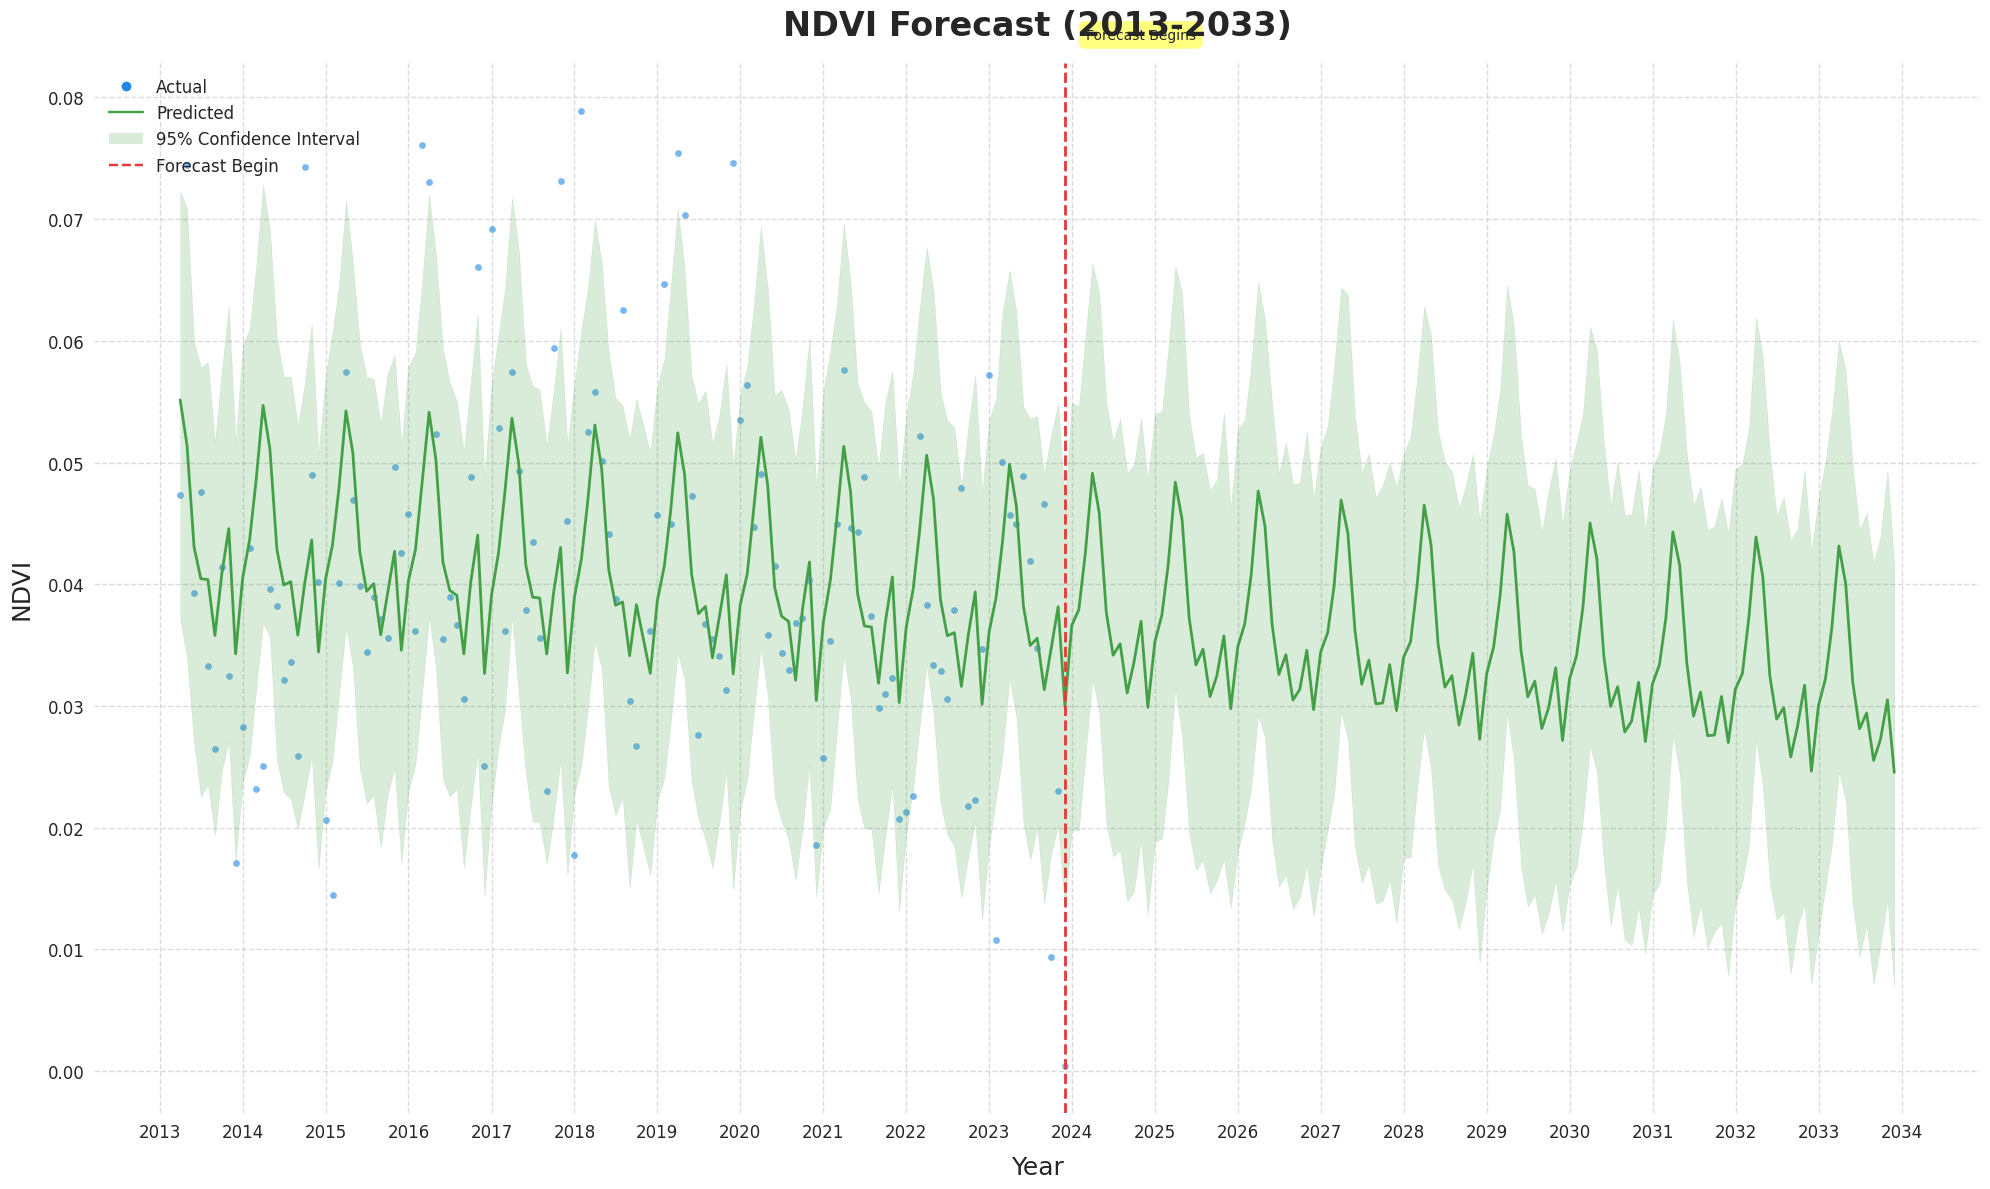

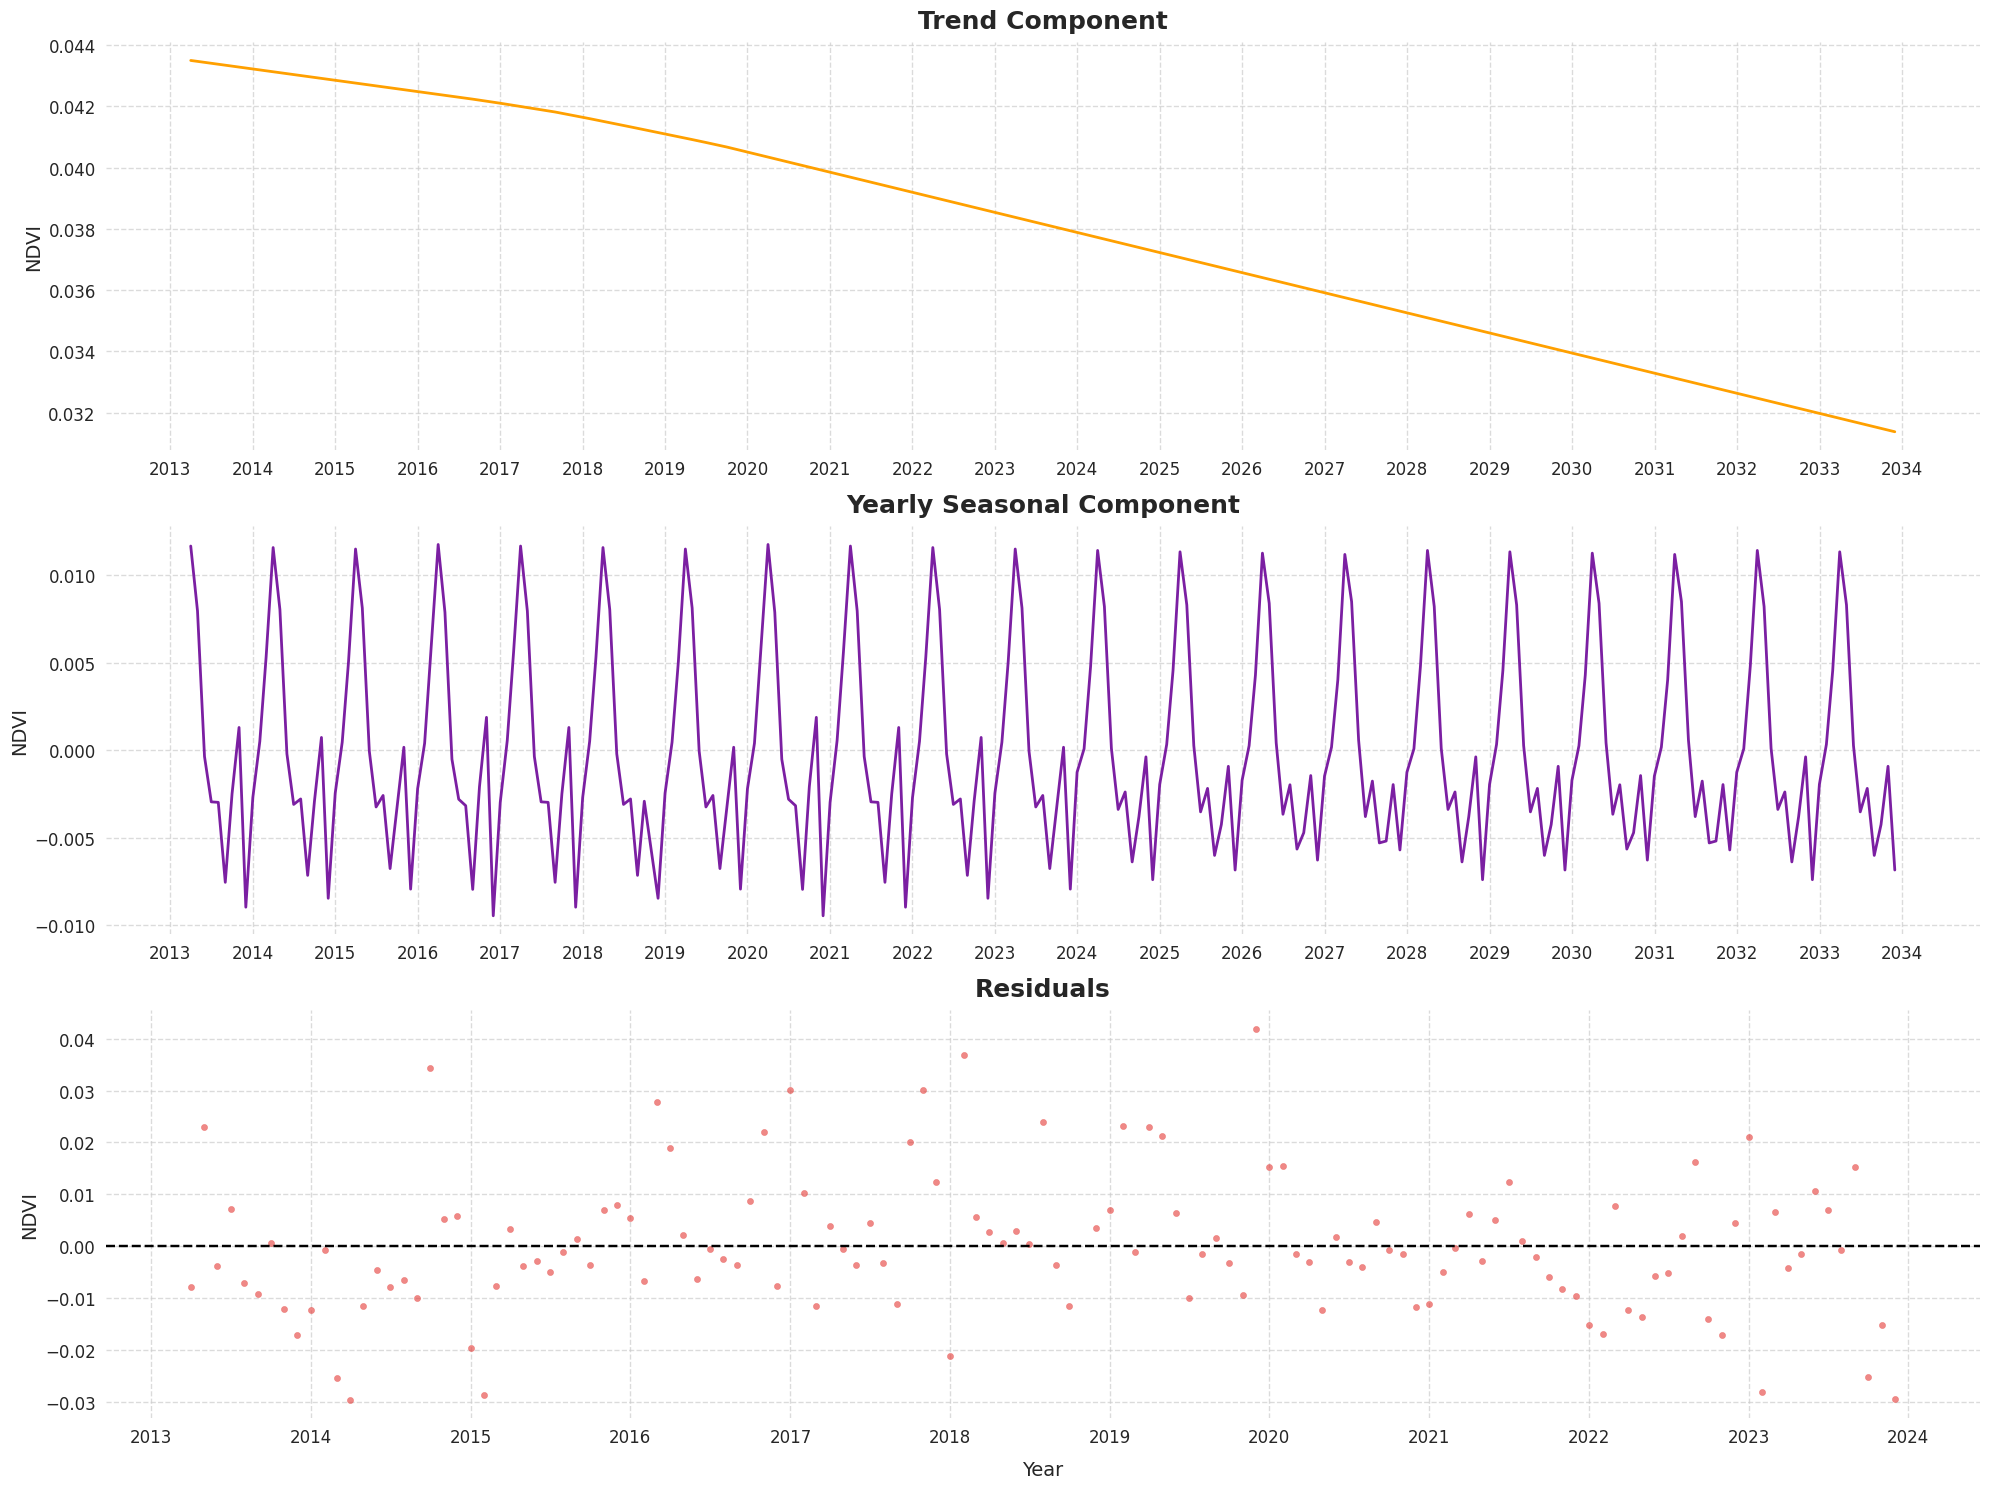

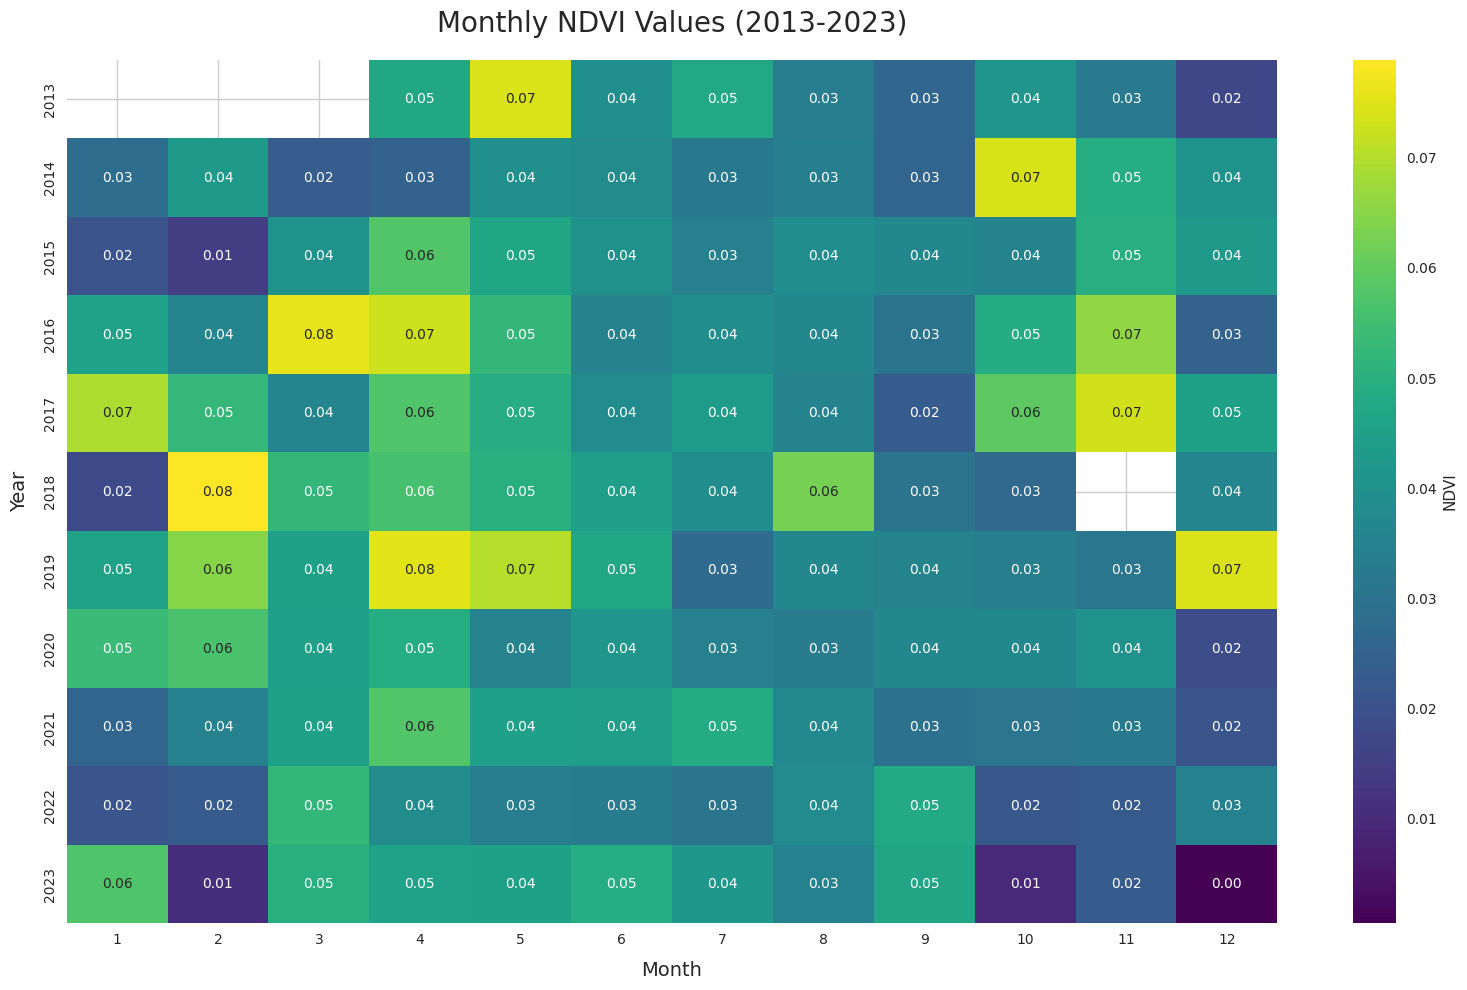

In [ ]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


# Preprocessing and cleaning
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
df = df.sort_values('Date')
df['NDVI'] = pd.to_numeric(df['NDVI'], errors='coerce')
df['NDVI'] = df.groupby('Month')['NDVI'].transform(lambda x: x.clip(lower=x.mean() - 3*x.std(), upper=x.mean() + 3*x.std()))
df['NDVI'] = df['NDVI'].interpolate()

# Prepare data for Prophet
prophet_df = df[['Date', 'NDVI']].rename(columns={'Date': 'ds', 'NDVI': 'y'})

# Create and fit the model
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False,
                changepoint_prior_scale=0.05, seasonality_prior_scale=10)
model.fit(prophet_df)

# Create future dataframe for predictions
future = model.make_future_dataframe(periods=120, freq='M')  # 10 years * 12 months
forecast = model.predict(future)

# Evaluate the model
train_predictions = forecast[forecast['ds'].isin(prophet_df['ds'])]['yhat']
mse = mean_squared_error(prophet_df['y'], train_predictions)
mae = mean_absolute_error(prophet_df['y'], train_predictions)
r2 = r2_score(prophet_df['y'], train_predictions)

print(f"Model Performance:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared: {r2:.4f}")

# Custom color palette
custom_palette = plt.cm.viridis

#####
# 1. Static Matplotlib Visualization
plt.figure(figsize=(20, 12))
ax = plt.gca()

# Plot actual values
ax.scatter(prophet_df['ds'], prophet_df['y'], color='#1e88e5', alpha=0.6, s=20, label='Actual')

# Plot predicted values
ax.plot(forecast['ds'], forecast['yhat'], color='#43a047', linewidth=2, label='Predicted')

# Plot confidence interval
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='#43a047', alpha=0.2)

# Customize the plot
ax.set_title('NDVI Forecast (2013-2033)', fontsize=24, fontweight='bold', pad=20)
ax.set_xlabel('Year', fontsize=18, labelpad=10)
ax.set_ylabel('NDVI', fontsize=18, labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

# Customize grid
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

# Customize x-axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add a vertical line to separate historical data from predictions
last_historical_date = prophet_df['ds'].max()
ax.axvline(x=last_historical_date, color='#e53935', linestyle='--', linewidth=2)

# Add annotation for forecast beginning
ax.annotate('Forecast Begins', xy=(last_historical_date, ax.get_ylim()[1]),
            xytext=(15, 15), textcoords='offset points',
            ha='left', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Customize legend
legend_elements = [
    Line2D([0], [0], color='#1e88e5', marker='o', linestyle='', label='Actual'),
    Line2D([0], [0], color='#43a047', label='Predicted'),
    Patch(facecolor='#43a047', edgecolor='none', alpha=0.2, label='95% Confidence Interval'),
    Line2D([0], [0], color='#e53935', linestyle='--', label='Forecast Begin')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=12)

plt.tight_layout()
plt.show()

# 2. Interactive Plotly Visualization
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1,
                    subplot_titles=('NDVI Forecast', 'Trend and Seasonality'))

####

# Actual values
fig.add_trace(go.Scatter(x=prophet_df['ds'], y=prophet_df['y'], mode='markers',
                         name='Actual', marker=dict(color='#1e88e5', size=6)), row=1, col=1)

# Predicted values
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines',
                         name='Predicted', line=dict(color='#43a047', width=2)), row=1, col=1)

# Confidence interval
fig.add_trace(go.Scatter(x=forecast['ds'].tolist() + forecast['ds'].tolist()[::-1],
                         y=forecast['yhat_upper'].tolist() + forecast['yhat_lower'].tolist()[::-1],
                         fill='toself', fillcolor='rgba(67,160,71,0.2)', line=dict(color='rgba(255,255,255,0)'),
                         hoverinfo="skip", showlegend=False), row=1, col=1)

# Trend
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['trend'], mode='lines',
                         name='Trend', line=dict(color='#ffa000', width=2)), row=2, col=1)

# Seasonality
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yearly'], mode='lines',
                         name='Yearly Seasonality', line=dict(color='#7b1fa2', width=2)), row=2, col=1)

# Update layout
fig.update_layout(
    height=800,
    title_text="NDVI Forecast with Trend and Seasonality (2013-2033)",
    title_font=dict(size=24),
    plot_bgcolor='rgba(240,240,240,0.8)',
    legend=dict(font=dict(size=12), bgcolor='rgba(255,255,255,0.5)', bordercolor='rgba(0,0,0,0.2)', borderwidth=1),
    hovermode="x unified",
    annotations=[
        dict(
            x=last_historical_date,
            y=1.05,
            xref="x",
            yref="paper",
            text="Forecast Begins",
            showarrow=True,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="#e53935",
            ax=50,
            ay=-40,
            bordercolor="#c7c7c7",
            borderwidth=2,
            borderpad=4,
            bgcolor="#ff9800",
            opacity=0.8
        )
    ]
)

fig.update_xaxes(title_text="Year", title_font=dict(size=18), tickfont=dict(size=12),
                 gridcolor='rgba(0,0,0,0.1)', row=2, col=1)
fig.update_yaxes(title_text="NDVI", title_font=dict(size=18), tickfont=dict(size=12),
                 gridcolor='rgba(0,0,0,0.1)', row=1, col=1)
fig.update_yaxes(title_text="NDVI Component", title_font=dict(size=18), tickfont=dict(size=12),
                 gridcolor='rgba(0,0,0,0.1)', row=2, col=1)

# Add a vertical line to separate historical data from predictions
fig.add_vline(x=last_historical_date, line_width=2, line_dash="dash", line_color="#e53935")

fig.show()


# 3. Seasonal Decomposition Plot
seasonal_fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 15))

# Trend
ax1.plot(forecast['ds'], forecast['trend'], color='#ffa000', linewidth=2)
ax1.set_title('Trend Component', fontsize=18, fontweight='bold', pad=10)
ax1.set_ylabel('NDVI', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)

# Yearly Seasonality
ax2.plot(forecast['ds'], forecast['yearly'], color='#7b1fa2', linewidth=2)
ax2.set_title('Yearly Seasonal Component', fontsize=18, fontweight='bold', pad=10)
ax2.set_ylabel('NDVI', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)

# Residuals
residuals = prophet_df['y'] - train_predictions
ax3.scatter(prophet_df['ds'], residuals, color='#e53935', alpha=0.6, s=20)
ax3.axhline(y=0, color='black', linestyle='--')
ax3.set_title('Residuals', fontsize=18, fontweight='bold', pad=10)
ax3.set_xlabel('Year', fontsize=14, labelpad=10)
ax3.set_ylabel('NDVI', fontsize=14)
ax3.tick_params(axis='both', which='major', labelsize=12)
ax3.grid(True, linestyle='--', alpha=0.7)

# Customize x-axis for all subplots
for ax in [ax1, ax2, ax3]:
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

# 4. Heatmap of Monthly NDVI Values
pivot_df = df.pivot(index='Year', columns='Month', values='NDVI')
plt.figure(figsize=(16, 10))
sns.heatmap(pivot_df, cmap='viridis', annot=True, fmt='.2f', cbar_kws={'label': 'NDVI'})
plt.title('Monthly NDVI Values (2013-2023)', fontsize=20, pad=20)
plt.xlabel('Month', fontsize=14, labelpad=10)
plt.ylabel('Year', fontsize=14, labelpad=10)
plt.tight_layout()
plt.show()

# Forest gain & loss

In [ ]:
import ee
import geemap
import ipywidgets as widgets
from ipyleaflet import WidgetControl

# Initialize Earth Engine
ee.Initialize()

# Define the area of interest (Absheron Peninsula)
aoi = ee.Geometry.Rectangle([49.5, 40.2, 50.2, 40.6])

# Load the Hansen Global Forest Change dataset
gfc = ee.Image("UMD/hansen/global_forest_change_2023_v1_11")

# Extract the forest cover, gain, and loss layers
treecover2000 = gfc.select(['treecover2000'])
gain = gfc.select(['gain'])
loss = gfc.select(['loss'])
lossyear = gfc.select(['lossyear'])

# Create a mask for areas that had forest cover in 2000
forest_mask = treecover2000.gt(30)  # Areas with >30% tree cover

# Apply the forest mask to gain and loss
gain_masked = gain.updateMask(forest_mask)
loss_masked = loss.updateMask(forest_mask)
lossyear_masked = lossyear.updateMask(forest_mask)

# Define enhanced visualization parameters
vis_params = {
    'gain': {'palette': ['#00FF00'], 'min': 0, 'max': 1},
    'loss': {'palette': ['#FF0000'], 'min': 0, 'max': 1},
    'treecover': {'palette': ['#000000', '#00FF00'], 'min': 0, 'max': 100},
    'lossyear': {'palette': ['#FF0000', '#FFA500', '#FFFF00', '#008000'], 'min': 1, 'max': 21}
}

# Create a map centered on the area of interest
Map = geemap.Map(center=[40.4, 49.85], zoom=10)

# Add the Earth Engine layers to the map
Map.addLayer(treecover2000.clip(aoi), vis_params['treecover'], 'Tree Cover 2000')
Map.addLayer(gain_masked.clip(aoi), vis_params['gain'], 'Forest Gain')
Map.addLayer(loss_masked.clip(aoi), vis_params['loss'], 'Forest Loss')
Map.addLayer(lossyear_masked.clip(aoi), vis_params['lossyear'], 'Year of Loss')

# Add administrative boundaries
countries = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")
azerbaijan = countries.filter(ee.Filter.eq('country_na', 'Azerbaijan'))
Map.addLayer(azerbaijan.style(**{'color': '#000000', 'fillColor': '#00000000'}), {}, 'Azerbaijan')

# Create a custom legend
legend_items = [
    ('Tree Cover 2000', '#00FF00'),
    ('Forest Gain', '#00FF00'),
    ('Forest Loss', '#FF0000'),
    ('Year of Loss', '#FF0000, #FFA500, #FFFF00, #008000')
]

legend_html = """
<div style="position: fixed; bottom: 50px; right: 50px; width: 150px; height: 160px;
    background-color: white; border-radius: 5px; box-shadow: 0 0 5px rgba(0,0,0,0.2);
    padding: 10px; font-size: 14px; z-index: 9999;">
    <strong>Legend</strong><br>
"""

for label, color in legend_items:
    if ',' in color:
        # Create a gradient for the Year of Loss
        gradient = f"linear-gradient(to right, {color})"
        legend_html += f"<div style='margin-top:5px;'><span style='display:inline-block; width:20px; height:20px; background: {gradient};'></span> {label}</div>"
    else:
        legend_html += f"<div style='margin-top:5px;'><span style='display:inline-block; width:20px; height:20px; background-color:{color};'></span> {label}</div>"

legend_html += "</div>"

legend_widget = widgets.HTML(value=legend_html)
legend_control = WidgetControl(widget=legend_widget, position='bottomright')
Map.add_control(legend_control)

# Calculate forest statistics
def calculate_forest_stats():
    area_gain = gain_masked.multiply(ee.Image.pixelArea()).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi,
        scale=30,
        maxPixels=1e9
    ).get('gain')

    area_loss = loss_masked.multiply(ee.Image.pixelArea()).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi,
        scale=30,
        maxPixels=1e9
    ).get('loss')

    area_gain_ha = ee.Number(area_gain).divide(10000).round()
    area_loss_ha = ee.Number(area_loss).divide(10000).round()
    net_change = area_gain_ha.subtract(area_loss_ha)

    return area_gain_ha.getInfo(), area_loss_ha.getInfo(), net_change.getInfo()

# Create a widget to display forest statistics
gain_ha, loss_ha, net_change = calculate_forest_stats()
stats_html = f"""
<div style="position: fixed; top: 50px; right: 50px; width: 200px;
    background-color: white; border-radius: 5px; box-shadow: 0 0 5px rgba(0,0,0,0.2);
    padding: 10px; font-size: 14px; z-index: 9999;">
    <h3 style="margin-top: 0;">Forest Change Statistics</h3>
    <ul style="padding-left: 20px; margin-bottom: 0;">
        <li>Forest Gain: {gain_ha} ha</li>
        <li>Forest Loss: {loss_ha} ha</li>
        <li>Net Change: {net_change} ha</li>
    </ul>
</div>
"""
stats_widget = widgets.HTML(value=stats_html)
stats_control = WidgetControl(widget=stats_widget, position='topleft')
Map.add_control(stats_control)

# Display the map
Map

Map(center=[40.4, 49.85], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

# LAND COVER TYPES ANALYSIS

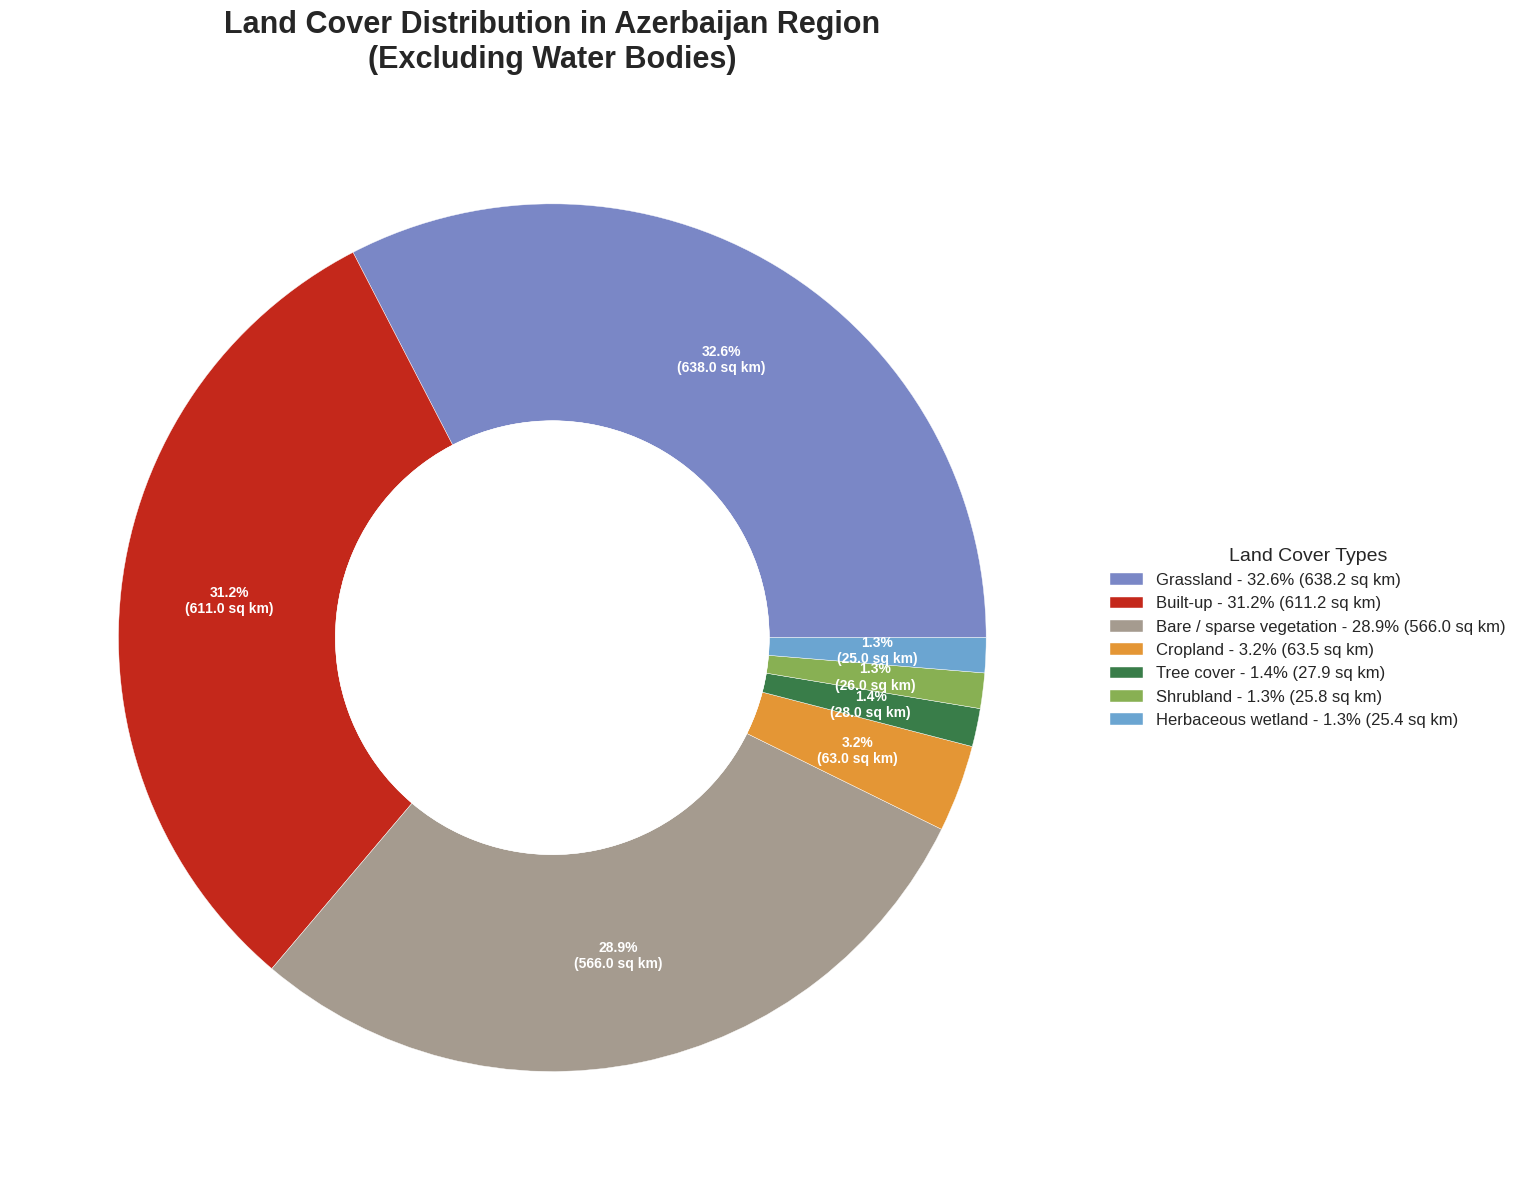

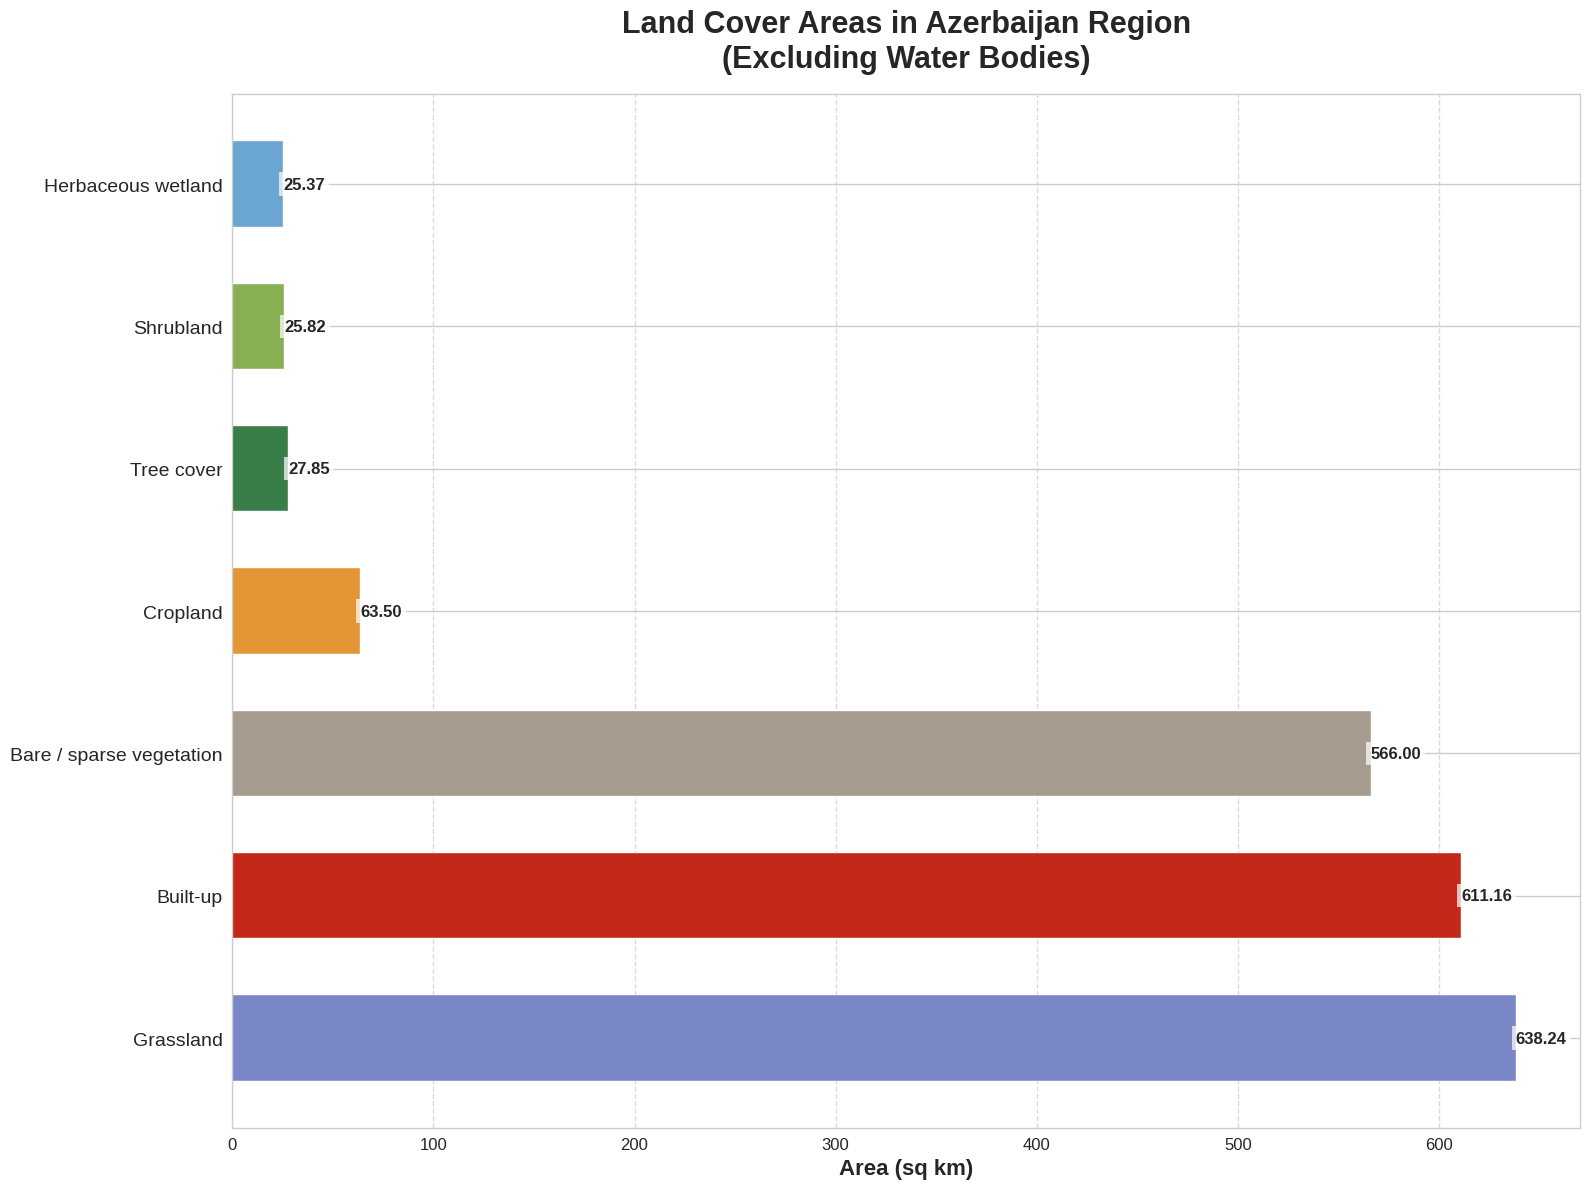


Total Land Area Analyzed (Excluding Water Bodies): 1957.95 sq km


In [ ]:
import ee
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Initialize Earth Engine
ee.Initialize()

def get_land_cover_data():


    worldcover = ee.ImageCollection("ESA/WorldCover/v100").first()

    land_cover_dict = {
        10: ('Tree cover', '#397D49'),
        20: ('Shrubland', '#88B053'),
        30: ('Grassland', '#7A87C6'),
        40: ('Cropland', '#E49635'),
        50: ('Built-up', '#C4281B'),
        60: ('Bare / sparse vegetation', '#A59B8F'),
        70: ('Snow and ice', '#B39FE1'),
        90: ('Herbaceous wetland', '#6BA5D1'),
        95: ('Mangroves', '#00CF75'),
        100: ('Moss and lichen', '#9F4A54')
    }

    land_cover = worldcover.select('Map').clip(aoi)
    area_image = ee.Image.pixelArea().addBands(land_cover)
    areas = area_image.reduceRegion(
        reducer=ee.Reducer.sum().group(1),
        geometry=aoi,
        scale=10,
        maxPixels=1e9
    ).getInfo()['groups']

    data = [(item['group'], item['sum'] / 1e6) for item in areas if item['group'] in land_cover_dict]
    classes, areas = zip(*data)
    labels = [land_cover_dict[cls][0] for cls in classes]
    colors = [land_cover_dict[cls][1] for cls in classes]

    sorted_data = sorted(zip(areas, labels, colors), reverse=True)
    areas, labels, colors = zip(*sorted_data)

    return areas, labels, colors

def create_donut_chart(areas, labels, colors):
    fig, ax = plt.subplots(figsize=(16, 12), subplot_kw=dict(aspect="equal"))

    def func(pct, allvals):
        absolute = int(round(pct/100.*sum(allvals)))
        return f"{pct:.1f}%\n({absolute:.1f} sq km)"

    wedges, texts, autotexts = ax.pie(areas, autopct=lambda pct: func(pct, areas),
                                      textprops=dict(color="w"), colors=colors,
                                      pctdistance=0.75, wedgeprops=dict(width=0.5))

    ax.set_title('Land Cover Distribution in Azerbaijan Region\n(Excluding Water Bodies)',
                 fontsize=22, fontweight='bold', pad=20)

    # Add a circle at the center to create a donut chart
    centre_circle = plt.Circle((0,0), 0.50, fc='white')
    fig.gca().add_artist(centre_circle)

    # Create legend with percentage and absolute value
    legend_labels = [f'{l} - {a/sum(areas)*100:.1f}% ({a:.1f} sq km)' for l, a in zip(labels, areas)]
    ax.legend(wedges, legend_labels, title="Land Cover Types",
              loc="center left", bbox_to_anchor=(1, 0, 0.5, 1),
              fontsize=12, title_fontsize=14)

    plt.setp(autotexts, size=10, weight="bold")
    plt.tight_layout()
    plt.show()

def create_bar_chart(areas, labels, colors):
    fig, ax = plt.subplots(figsize=(16, 12))
    bars = ax.barh(labels, areas, color=colors, height=0.6)
    ax.set_xlabel('Area (sq km)', fontsize=16, fontweight='bold')
    ax.set_title('Land Cover Areas in Azerbaijan Region\n(Excluding Water Bodies)',
                 fontsize=22, fontweight='bold', pad=20)

    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=12)

    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2f}',
                ha='left', va='center', fontweight='bold', fontsize=12,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=3))

    ax.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

areas, labels, colors = get_land_cover_data()
create_donut_chart(areas, labels, colors)
create_bar_chart(areas, labels, colors)

total_area = sum(areas)
print(f'\nTotal Land Area Analyzed (Excluding Water Bodies): {total_area:.2f} sq km')

# BASIC EXPLATORY DATA ANALYSIS OF THE AREA

In [18]:

# Visualization parameters for different indices
vis_params = {
    'NDVI': {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']},
    'NDWI': {'min': -1, 'max': 1, 'palette': ['red', 'white', 'blue']},
    'NBR': {'min': -1, 'max': 1, 'palette': ['red', 'white', 'green']},
    'TGSI': {'min': -0.2, 'max': 0.2, 'palette': ['blue', 'white', 'orange', 'red']},
    'Albedo': {'min': 0, 'max': 1, 'palette': ['blue', 'yellow', 'orange', 'red']},
    'LST': {'min': 20, 'max': 45, 'palette': ['blue', 'limegreen', 'yellow', 'darkorange', 'red']}
}

# Function to mask clouds in Landsat 8 imagery
def mask_clouds(image):
    qa = image.select('QA_PIXEL')
    cloud_mask = qa.bitwiseAnd(1 << 3).eq(0) and qa.bitwiseAnd(1 << 5).eq(0)
    return image.updateMask(cloud_mask)

# Function to scale Landsat 8 surface reflectance values
def scale_sr(image):
    optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    return image.addBands(optical_bands, None, True).addBands(thermal_bands, None, True)

# Get Landsat 8 Surface Reflectance Tier 1 collection
l8_collection = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                 .filterBounds(aoi)
                 .filterDate(start_date, end_date)
                 .filter(ee.Filter.calendarRange(6, 6, 'month'))
                 .map(mask_clouds)
                 .map(scale_sr))

# Function to calculate indices
def calculate_indices(image):
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    ndwi = image.normalizedDifference(['SR_B3', 'SR_B5']).rename('NDWI')
    nbr = image.normalizedDifference(['SR_B5', 'SR_B7']).rename('NBR')
    albedo = image.expression(
        '((0.356 * BLUE) + (0.130 * GREEN) + (0.373 * RED) + (0.085 * NIR) + (0.072 * SWIR) - 0.018) / 1.016',
        {'BLUE': image.select('SR_B2'),
         'GREEN': image.select('SR_B3'),
         'RED': image.select('SR_B4'),
         'NIR': image.select('SR_B5'),
         'SWIR': image.select('SR_B6')
         }
    ).rename('Albedo')
    tgsi = image.expression(
        '(RED - BLUE) / (RED + BLUE + GREEN)',
        {'BLUE': image.select('SR_B2'),
         'GREEN': image.select('SR_B3'),
         'RED': image.select('SR_B4')
         }
    ).rename('TGSI')


    # Land Surface Temperature (LST) calculation
    bt = image.select('ST_B10')
    ndvi_for_lst = image.normalizedDifference(['SR_B5', 'SR_B4'])
    pv = ndvi_for_lst.subtract(0.2).divide(0.5).pow(2)
    e = pv.multiply(0.004).add(0.986)
    lst = bt.expression(
        '(Tb / (1 + (0.00115 * Tb / 1.4388) * log(e)))',
        {'Tb': bt, 'e': e}
    ).subtract(273.15).rename('LST')

    return image.addBands([ndvi, ndwi, nbr, lst, albedo, tgsi])


# Apply indices calculation to the collection
l8_final = l8_collection.map(calculate_indices)

# Function to visualize an image
def visualize_image(image, vis_params, title):
    try:
        map_image = geemap.Map()
        map_image.centerObject(aoi, 10)
        map_image.addLayer(image.clip(aoi), vis_params, title)
        map_image.addLayerControl()
        return map_image
    except Exception as e:
        print(f"Error visualizing {title}: {str(e)}")
        return None

# Function to create time series
def create_time_series(collection, band_name, scale=30):
    def extract_value(image):
        stats = image.select(band_name).reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=aoi,
            scale=scale
        )
        return ee.Feature(None, {
            'value': stats.get(band_name),
            'date': image.date().millis()
        })

    time_series = collection.map(extract_value).getInfo()
    return [(feat['properties']['date'], feat['properties']['value']) for feat in time_series['features'] if feat['properties']['value'] is not None]

# Function to perform ARIMA analysis
def perform_arima_analysis(time_series, order=(1,1,1)):
    if len(time_series) < 10:
        print(f"Not enough data points for ARIMA analysis. Only {len(time_series)} points available.")
        return None
    dates, values = zip(*sorted(time_series))
    model = ARIMA(values, order=order)
    try:
        results = model.fit()
        return results
    except Exception as e:
        print(f"Error in ARIMA analysis: {str(e)}")
        return None

# Function to visualize time series and ARIMA forecast
def visualize_time_series_and_forecast(time_series, arima_results, title):
    if not time_series:
        print(f"No data available for {title}")
        return

    dates, values = zip(*sorted(time_series))
    dates = [ee.Date(date).getInfo()['value'] for date in dates]

    plt.figure(figsize=(12, 6))
    plt.plot(dates, values, label='Observed')

    if arima_results is not None:
        plt.plot(dates, arima_results.fittedvalues, color='red', label='ARIMA Fitted')

        forecast = arima_results.forecast(steps=12)
        last_date = ee.Date(dates[-1])
        future_dates = [last_date.advance(i, 'month').getInfo()['value'] for i in range(1, 13)]
        plt.plot(future_dates, forecast, color='green', label='ARIMA Forecast')

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Basic analysis pipeline

def run_analysis_part1():
    print("Starting basic analysis part1...")

    # Visualize a sample image with calculated indices
    print("Visualizing indices...")
    sample_image = l8_final.first()

    # Print available bands for debugging
    print("Available bands:", sample_image.bandNames().getInfo())

    for band, params in vis_params.items():
        print(f"Visualizing {band}...")
        map_vis = visualize_image(sample_image.select(band), params, f'{band} Visualization')
        if map_vis:
            display(map_vis)
    print("Basic analysis part1 complete!")

def run_analysis_part2():
    print("Starting basic analysis part2...")

    # Create and visualize time series for each index
    print("Creating time series and performing ARIMA analysis...")
    indices = ['NDVI', 'NDWI', 'NBR', 'TGSI', 'LST', 'Albedo']
    for index in indices:
        print(f"Processing {index}...")
        ts = create_time_series(l8_final, index)
        if ts:
            arima_results = perform_arima_analysis(ts)
            visualize_time_series_and_forecast(ts, arima_results, f'{index} Time Series and ARIMA Forecast')
        else:
            print(f"No valid data for {index}")

    print("Basic analysis part2 complete!")

In [19]:
# Run the basic analysis part1, this is just for demo
if __name__ == "__main__":
    run_analysis_part1()

Starting basic analysis part1...
Visualizing indices...
Available bands: ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'SR_QA_AEROSOL', 'ST_B10', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_TRAD', 'ST_URAD', 'QA_PIXEL', 'QA_RADSAT', 'NDVI', 'NDWI', 'NBR', 'LST', 'Albedo', 'TGSI']
Visualizing NDVI...


KeyboardInterrupt: 

In [ ]:
# Run the basic analysis part2, this is just for demo
if __name__ == "__main__":
    run_analysis_part2()

# PREVIOUS STEPS: Trying different approaches

Getting metadata of landsat 8 imagery

In [ ]:
#METADATA TABLE

def get_image_metadata(aoi, start_year, end_year):
    # Define the date range
    start_date = ee.Date.fromYMD(start_year, 1, 1)
    end_date = ee.Date.fromYMD(end_year, 12, 31)

    # Get the Landsat 8 collection
    collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterBounds(aoi) \
        .filterDate(start_date, end_date) \
        .sort('system:time_start')

    # Function to extract metadata from an image
    def extract_metadata(image):
        return ee.Feature(None, {
            'id': image.id(),
            'date': image.date().format('YYYY-MM-dd'),
            'time': image.get('SCENE_CENTER_TIME'),
            'cloud_cover': image.get('CLOUD_COVER'),
            'sun_azimuth': image.get('SUN_AZIMUTH'),
            'sun_elevation': image.get('SUN_ELEVATION'),
            'spacecraft_id': image.get('SPACECRAFT_ID'),
            'wrs_path': image.get('WRS_PATH'),
            'wrs_row': image.get('WRS_ROW')
        })

    # Map the metadata extraction over the collection
    metadata_collection = collection.map(extract_metadata)

    # Get the metadata as a list of dictionaries
    metadata_list = metadata_collection.getInfo()['features']

    # Convert to a pandas DataFrame
    df_metadata = pd.DataFrame([f['properties'] for f in metadata_list])

    # Convert date to datetime and sort
    df_metadata['date'] = pd.to_datetime(df_metadata['date'])
    df_metadata = df_metadata.sort_values('date')

    return df_metadata


# Get image metadata
metadata_df = get_image_metadata(aoi, 2013, 2023)

# Display the metadata table
display(metadata_df)

# Optional: Save to CSV
metadata_df.to_csv('landsat8_metadata.csv', index=False)

# Print some summary statistics
print(f"Total number of images: {len(metadata_df)}")
print(f"Date range: {metadata_df['date'].min()} to {metadata_df['date'].max()}")
print("\nAverage cloud cover by year:")
print(metadata_df.groupby(metadata_df['date'].dt.year)['cloud_cover'].mean())

cloud_cover       date                    id spacecraft_id  sun_azimuth  \
0          43.91 2013-04-14  LC08_167032_20130414     LANDSAT_8   145.318578   
1          35.92 2013-04-23  LC08_166032_20130423     LANDSAT_8   143.552292   
2          74.36 2013-05-16  LC08_167032_20130516     LANDSAT_8   137.688793   
3          44.59 2013-05-25  LC08_166032_20130525     LANDSAT_8   135.083428   
4           7.84 2013-06-10  LC08_166032_20130610     LANDSAT_8   131.002586   
..           ...        ...                   ...           ...          ...   
585        98.06 2023-12-06  LC08_167031_20231206     LANDSAT_8   162.610274   
586        97.73 2023-12-06  LC08_167032_20231206     LANDSAT_8   162.056318   
587        93.31 2023-12-15  LC08_166032_20231215     LANDSAT_8   161.279520   
588        87.76 2023-12-22  LC08_167031_20231222     LANDSAT_8   161.048156   
589        58.01 2023-12-22  LC08_167032_20231222     LANDSAT_8   160.499709   

     sun_elevation               time  wrs_path  wrs_row  
0        54.635896  07:27:15.9315240Z       167       32  
1        57.630150  07:21:02.6648120Z       166       32  
2        63.532328  07:27:26.0236650Z       167       32  
3        64.982265  07:21:19.2394790Z       166       32  
4        66.263147  07:21:17.1783820Z       166       32  
..             ...                ...       ...      ...  
585      23.823590  07:25:08.9167299Z       167       31  
586      25.100104  07:25:32.8035340Z       167       32  
587      24.092822  07:19:27.7459730Z       166       32  
588      22.444626  07:25:16.4085790Z       167       31  
589      23.701569  07:25:40.2911470Z       167       32  

[590 rows x 9 columns]

Total number of images: 590
Date range: 2013-04-14 00:00:00 to 2023-12-22 00:00:00

Average cloud cover by year:
date
2013    41.627429
2014    38.256727
2015    35.519608
2016    42.592245
2017    33.583818
2018    42.644615
2019    44.846066
2020    35.240351
2021    36.837833
2022    36.651111
2023    46.704098
Name: cloud_cover, dtype: float64


In [20]:
# Landsat 8 Data Preparation Functions
def mask_clouds(image):
    qa = image.select('QA_PIXEL')
    cloud_mask = qa.bitwiseAnd(1 << 3).eq(0) and qa.bitwiseAnd(1 << 5).eq(0)
    return image.updateMask(cloud_mask)

def scale_sr(image):
    optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    return image.addBands(optical_bands, None, True).addBands(thermal_bands, None, True)

def calculate_indices(image):
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    ndwi = image.normalizedDifference(['SR_B3', 'SR_B5']).rename('NDWI')
    nbr = image.normalizedDifference(['SR_B5', 'SR_B7']).rename('NBR')
    albedo = image.expression(
        '((0.356 * BLUE) + (0.130 * GREEN) + (0.373 * RED) + (0.085 * NIR) + (0.072 * SWIR) - 0.018) / 1.016',
        {'BLUE': image.select('SR_B2'),
         'GREEN': image.select('SR_B3'),
         'RED': image.select('SR_B4'),
         'NIR': image.select('SR_B5'),
         'SWIR': image.select('SR_B6'),
         }
    ).rename('Albedo')
    tgsi = image.expression(
        '(RED - BLUE) / (RED + BLUE + GREEN)',
        {'BLUE': image.select('SR_B2'),
         'GREEN': image.select('SR_B3'),
         'RED': image.select('SR_B4'),
         }
    ).rename('TGSI')

    # Land Surface Temperature (LST) calculation
    bt = image.select('ST_B10')
    ndvi_for_lst = image.normalizedDifference(['SR_B5', 'SR_B4'])
    pv = ndvi_for_lst.subtract(0.2).divide(0.5).pow(2)
    e = pv.multiply(0.004).add(0.986)
    lst = bt.expression(
        '(Tb / (1 + (0.00115 * Tb / 1.4388) * log(e)))',
        {'Tb': bt, 'e': e}
    ).subtract(273.15).rename('LST')

    return image.addBands([ndvi, ndwi, nbr, tgsi, albedo, lst])

In [21]:
# Load and Preprocess Landsat 8 Data
l8_collection = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                 .filterBounds(aoi)
                 .filterDate(start_date, end_date)
                 .filter(ee.Filter.calendarRange(6, 6, 'month'))
                 .map(mask_clouds)
                 .map(scale_sr)
                 .map(calculate_indices))

print("Updated index calculation function with Desertification Index.")


Updated index calculation function with Desertification Index.


In [22]:
# Change Detection Analysis
def perform_change_detection():
    early_period = l8_collection.filterDate('2013-06-01', '2013-06-30')
    late_period = l8_collection.filterDate('2024-06-01', '2024-06-30')

    early_composite = early_period.mean()
    late_composite = late_period.mean()

    ndvi_diff = late_composite.select('NDVI').subtract(early_composite.select('NDVI')).rename('NDVI_diff')

    return ndvi_diff

ndvi_diff = perform_change_detection()
print("Change detection analysis completed.")

# Zonal Statistics
def perform_zonal_statistics():
    admin_districts = ee.FeatureCollection("FAO/GAUL/2015/level2").filter(ee.Filter.eq('ADM0_NAME', 'Azerbaijan'))

    mean_ndvi = l8_collection.select('NDVI').mean()

    def calculate_district_stats(district):
        mean_ndvi_value = mean_ndvi.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=district.geometry(),
            scale=500,
            maxPixels=1e9
        ).get('NDVI')
        return district.set('mean_ndvi', mean_ndvi_value)

    districts_with_stats = admin_districts.map(calculate_district_stats)

    return districts_with_stats

districts_with_stats = perform_zonal_statistics()
print("Zonal statistics calculation completed.")

# Time Series and Trend Analysis (Updated)

def create_time_series(collection, band_name, scale=500):
    def extract_value(image):
        stats = image.select(band_name).reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=aoi,
            scale=scale,
            maxPixels=1e9
        )
        return ee.Feature(None, {
            'value': stats.get(band_name),
            'date': image.date().millis()
        })

    time_series = collection.map(extract_value).getInfo()
    return [(feat['properties']['date'], feat['properties']['value'])
            for feat in time_series['features']
            if 'value' in feat['properties'] and feat['properties']['value'] is not None]

def perform_trend_analysis():
    indices = ['NDVI', 'NDWI', 'NBR', 'LST', 'TGSI', 'Albedo']
    trends = []

    for index in indices:
        ts = create_time_series(l8_collection, index)
        if len(ts) >= 2:
            dates, values = zip(*sorted(ts))

            # Convert dates to numerical values (days since the start)
            start_date = min(dates)
            days = [(date - start_date) / (24 * 60 * 60 * 1000) for date in dates]

            slope, intercept, r_value, p_value, std_err = linregress(days, values)
            trends.append({
                'index': index,
                'slope': slope,
                'p_value': p_value,
                'r_value': r_value,
                'num_observations': len(ts)
            })
        else:
            print(f"Not enough valid data points for {index} trend analysis.")

    return trends

# Run the trend analysis
trends = perform_trend_analysis()

# Print the results
for trend in trends:
    print(f"{trend['index']}:")
    print(f"  Slope: {trend['slope']:.6f} per day")
    print(f"  P-value: {trend['p_value']:.6f}")
    print(f"  R-value: {trend['r_value']:.6f}")
    print(f"  Number of observations: {trend['num_observations']}")
    print()

print("Time series and trend analysis completed.")

# Advanced Visualization Function
def advanced_visualization(data, viz_type, title, **kwargs):
    if viz_type == 'map':
        return create_interactive_map(data, title, **kwargs)
    elif viz_type == 'chart':
        return create_interactive_chart(data, title, **kwargs)
    elif viz_type == 'heatmap':
        return create_heatmap(data, title, **kwargs)
    elif viz_type == 'timeseries':
        return create_timeseries_plot(data, title, **kwargs)
    else:
        raise ValueError(f"Unsupported visualization type: {viz_type}")

def create_interactive_map(data, title, **kwargs):
    map_center = kwargs.get('map_center', [40.4, 49.8])
    zoom = kwargs.get('zoom', 8)
    vis_params = kwargs.get('vis_params', {})

    m = geemap.Map(center=map_center, zoom=zoom)

    if isinstance(data, ee.Image):
        m.addLayer(data.clip(aoi), vis_params, title)
    elif isinstance(data, ee.FeatureCollection):
        m.addLayer(data, {}, title)

    m.add_colorbar(vis_params, label=title)

    return m

def create_interactive_chart(data, title, **kwargs):
    chart_type = kwargs.get('chart_type', 'bar')
    x = kwargs.get('x', [])
    y = kwargs.get('y', [])

    fig = go.Figure()

    if chart_type == 'bar':
        fig.add_trace(go.Bar(x=x, y=y))
    elif chart_type == 'scatter':
        fig.add_trace(go.Scatter(x=x, y=y, mode='markers'))

    fig.update_layout(title=title, xaxis_title=kwargs.get('xaxis_title', ''), yaxis_title=kwargs.get('yaxis_title', ''))

    return fig

def create_heatmap(data, title, **kwargs):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(data, annot=True, cmap=kwargs.get('cmap', 'YlOrRd'), ax=ax)
    ax.set_title(title)
    return fig

def create_timeseries_plot(data, title, **kwargs):
    fig = go.Figure()

    for series in data:
        fig.add_trace(go.Scatter(x=series['dates'], y=series['values'], name=series['name']))

    fig.update_layout(title=title, xaxis_title='Date', yaxis_title='Value')

    return fig

print("Advanced visualization functions defined.")

# Visualization Options
visualization_options = {
    'NDVI': l8_collection.select('NDVI').mean(),
    'NDWI': l8_collection.select('NDWI').mean(),
    'LST': l8_collection.select('LST').mean(),
    'TGSI': l8_collection.select('TGSI').mean(),
    'Albedo': l8_collection.select('Albedo').mean(),
    'NDVI_change': ndvi_diff,
    'district_stats': districts_with_stats,
    'trend_analysis': trends
}

print("Visualization options prepared.")
print("\nAvailable visualization options:")
for key in visualization_options.keys():
    print(f"- {key}")

Change detection analysis completed.
Zonal statistics calculation completed.
NDVI:
  Slope: 0.000015 per day
  P-value: 0.253900
  R-value: 0.152250
  Number of observations: 58

NDWI:
  Slope: 0.000003 per day
  P-value: 0.848151
  R-value: 0.025698
  Number of observations: 58

NBR:
  Slope: -0.000043 per day
  P-value: 0.064688
  R-value: -0.242101
  Number of observations: 59

LST:
  Slope: 0.006371 per day
  P-value: 0.016138
  R-value: 0.314675
  Number of observations: 58

TGSI:
  Slope: 0.000861 per day
  P-value: 0.316776
  R-value: 0.132593
  Number of observations: 59

Albedo:
  Slope: -0.000040 per day
  P-value: 0.015883
  R-value: -0.312735
  Number of observations: 59

Time series and trend analysis completed.
Advanced visualization functions defined.
Visualization options prepared.

Available visualization options:
- NDVI
- NDWI
- LST
- TGSI
- Albedo
- NDVI_change
- district_stats
- trend_analysis


Trying analysis dashboard and other diffrent aproaches

In [23]:
# Analysis Dashboard

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
import ee

def create_enhanced_dashboard():
    # Create a 3x3 subplot figure
    fig = make_subplots(
        rows=3, cols=3,
        subplot_titles=(
            "NDVI Change Map", "Trend Analysis", "Time Series of Key Indices",
            "Zonal Statistics Heatmap", "LST Distribution", "NDWI vs NDVI Scatter",
            "Desertification Index", "Monthly NDVI Boxplot", "Land Cover Change"
        ),
        specs=[
            [{"type": "mapbox"}, {"type": "xy"}, {"type": "xy"}],
            [{"type": "heatmap"}, {"type": "xy"}, {"type": "xy"}],
            [{"type": "mapbox"}, {"type": "box"}, {"type": "xy"}]
        ],
        vertical_spacing=0.08,
        horizontal_spacing=0.05
    )

    # 1. NDVI Change Map
    ndvi_change_image = visualization_options['NDVI_change'].getMapId({'min': -0.5, 'max': 0.5, 'palette': ['red', 'white', 'green']})
    fig.add_trace(go.Scattermapbox(
        lat=[40.2, 40.8, 40.8, 40.2],
        lon=[49.5, 49.5, 50.5, 50.5],
        mode='lines',
        fill='toself',
        fillcolor='rgba(0,0,0,0)',
        line_color='rgba(0,0,0,0)',
        showlegend=False,
        hoverinfo='skip'
    ), row=1, col=1)

    fig.update_mapboxes(
        style="carto-positron",
        zoom=8,
        center={"lat": 40.4, "lon": 50.0},
        layers=[{
            "sourcetype": "raster",
            "source": [f"https://earthengine.googleapis.com/map/{ndvi_change_image['mapid']}/{{'x':'{{x}}','y':'{{y}}','z':'{{z}}'}}"],
            "below": "traces"
        }]
    )

    # 2. Trend Analysis Chart
    indices = [t['index'] for t in trends]
    slopes = [t['slope'] * 365 for t in trends]  # Convert to annual change
    p_values = [t['p_value'] for t in trends]
    colors = ['green' if slope > 0 else 'red' for slope in slopes]

    fig.add_trace(go.Bar(
        x=indices,
        y=slopes,
        marker_color=colors,
        text=[f"Slope: {s:.4f}<br>p-value: {p:.4f}" for s, p in zip(slopes, p_values)],
        textposition='auto',
        name='Annual Trend'
    ), row=1, col=2)

    fig.update_yaxes(title_text="Annual Change", row=1, col=2)

    # 3. Time Series of Key Indices
    for index in ['NDVI', 'NDWI', 'LST', 'TGSI', 'Albedo']:
        ts = create_time_series(l8_collection, index)
        dates = [pd.to_datetime(d, unit='ms') for d, _ in ts]
        values = [v for _, v in ts]
        fig.add_trace(go.Scatter(
            x=dates,
            y=values,
            mode='lines',
            name=index
        ), row=1, col=3)

    fig.update_xaxes(title_text="Date", row=1, col=3)
    fig.update_yaxes(title_text="Value", row=1, col=3)

    # 4. Zonal Statistics Heatmap
    district_stats = districts_with_stats.getInfo()['features']
    district_names = [d['properties']['ADM2_NAME'] for d in district_stats if 'ADM2_NAME' in d['properties']]
    ndvi_values = [d['properties']['mean_ndvi'] for d in district_stats if 'mean_ndvi' in d['properties']]

    # Sort districts by NDVI value
    sorted_data = sorted(zip(district_names, ndvi_values), key=lambda x: x[1], reverse=True)
    district_names, ndvi_values = zip(*sorted_data)

    fig.add_trace(go.Heatmap(
        z=[ndvi_values],
        x=district_names,
        y=['Mean NDVI'],
        colorscale='emrld',
        colorbar=dict(title='NDVI')
    ), row=2, col=1)

    fig.update_xaxes(title_text="Districts", row=2, col=1)

    # 5. LST Distribution
    lst_values = [v for _, v in create_time_series(l8_collection, 'LST')]
    fig.add_trace(go.Histogram(
        x=lst_values,
        nbinsx=30,
        name='LST Distribution'
    ), row=2, col=2)
    fig.update_xaxes(title_text="Land Surface Temperature (°C)", row=2, col=2)
    fig.update_yaxes(title_text="Frequency", row=2, col=2)

    # 6. NDWI vs NDVI Scatter
    ndvi_ts = create_time_series(l8_collection, 'NDVI')
    ndwi_ts = create_time_series(l8_collection, 'NDWI')
    ndvi_values = [v for _, v in ndvi_ts]
    ndwi_values = [v for _, v in ndwi_ts]

    fig.add_trace(go.Scatter(
        x=ndvi_values,
        y=ndwi_values,
        mode='markers',
        marker=dict(
            size=5,
            color=lst_values,
            colorscale='Viridis',
            colorbar=dict(title="LST (°C)")
        ),
        name='NDWI vs NDVI'
    ), row=2, col=3)
    fig.update_xaxes(title_text="NDVI", row=2, col=3)
    fig.update_yaxes(title_text="NDWI", row=2, col=3)

    # 8. Monthly NDVI Boxplot
    ndvi_ts = create_time_series(l8_collection, 'NDVI')
    ndvi_df = pd.DataFrame(ndvi_ts, columns=['date', 'NDVI'])
    ndvi_df['date'] = pd.to_datetime(ndvi_df['date'], unit='ms')
    ndvi_df['month'] = ndvi_df['date'].dt.month

    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    fig.add_trace(go.Box(
        x=ndvi_df['month'].map(lambda x: month_names[x-1]),
        y=ndvi_df['NDVI'],
        name='Monthly NDVI'
    ), row=3, col=2)
    fig.update_xaxes(title_text="Month", row=3, col=2)
    fig.update_yaxes(title_text="NDVI", row=3, col=2)

    # 9. Land Cover Change
    # For this example, we'll use a simplified land cover classification
    def simple_landcover(image):
        ndvi = image.select('NDVI')
        water = ndvi.lt(0).rename('Water')
        vegetation = ndvi.gte(0.2).rename('Vegetation')
        barren = ndvi.lt(0.2).And(ndvi.gte(0)).rename('Barren')
        return image.addBands(water).addBands(vegetation).addBands(barren)

    # Land Cover Change Analysis
    early_landcover = l8_collection.filterDate('2013-06-01', '2013-06-30').map(simple_landcover).select(['Water', 'Vegetation', 'Barren']).mean()
    late_landcover = l8_collection.filterDate('2024-06-01', '2024-06-30').map(simple_landcover).select(['Water', 'Vegetation', 'Barren']).mean()

    early_areas = early_landcover.multiply(ee.Image.pixelArea()).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi,
        scale=30,
        maxPixels=1e9
    ).getInfo()

    late_areas = late_landcover.multiply(ee.Image.pixelArea()).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi,
        scale=30,
        maxPixels=1e9
    ).getInfo()

    land_cover_types = list(early_areas.keys())
    early_values = [early_areas[lc] / 1e6 for lc in land_cover_types]  # Convert to km²
    late_values = [late_areas[lc] / 1e6 for lc in land_cover_types]  # Convert to km²


    fig.add_trace(go.Bar(
        x=land_cover_types,
        y=early_values,
        name='Early Period'
    ), row=3, col=3)

    fig.add_trace(go.Bar(
        x=land_cover_types,
        y=late_values,
        name='Late Period'
    ), row=3, col=3)

    fig.update_xaxes(title_text="Land Cover Type", row=3, col=3)
    fig.update_yaxes(title_text="Area (km²)", row=3, col=3)

    # Update layout
    fig.update_layout(
        height=1800,
        width=2000,
        title_text="Desertification and Land Degradation Analysis Dashboard",
        mapbox_style="carto-positron",
        mapbox_zoom=7,
        mapbox_center={"lat": 40.4, "lon": 50.0},
    )

    return fig

# Create and display the enhanced dashboard
enhanced_dashboard = create_enhanced_dashboard()
enhanced_dashboard.show()

print("Analysis dashboard created and displayed.")

Analysis dashboard created and displayed.


Trying ML analysis

In [24]:
#ML Analysis
collection_size = l8_collection.size().getInfo()
print("Collection size:", collection_size)

def perform_advanced_ml_analysis(l8_collection, aoi):
    print("Performing machine learning analysis...")

    # 1. Prepare the data
    def extract_features(image):
        features = image.select(['NDVI', 'NDWI', 'LST', 'Albedo'])
        reduced = features.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=aoi,
            scale=30,
            maxPixels=1e9
        )
        return ee.Feature(None, reduced).set('date', image.date().millis())

    feature_collection = l8_collection.map(extract_features)
    data = pd.DataFrame([feat['properties'] for feat in feature_collection.getInfo()['features']])
    data['date'] = pd.to_datetime(data['date'], unit='ms')
    data = data.set_index('date').sort_index()

    # Add temporal features
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day_of_year'] = data.index.dayofyear

    # 2. Prepare features and target
    features = ['NDWI', 'LST', 'Albedo', 'year', 'month', 'day_of_year']
    X = data[features]
    y = data['NDVI']

    # 3. Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 4. Train the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # 5. Make predictions
    y_pred = rf_model.predict(X_test)

    # 6. Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"R-squared Score: {r2}")

    # 7. Feature Importance
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)

    # 8. Visualizations
    plt.figure(figsize=(20, 20))

    # 8.1 Actual vs Predicted NDVI
    plt.subplot(3, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual NDVI')
    plt.ylabel('Predicted NDVI')
    plt.title('Actual vs Predicted NDVI')

    # 8.2 Feature Importance
    plt.subplot(3, 2, 2)
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Feature Importance')
    plt.xlabel('Importance')

    # 8.3 Residuals Plot
    plt.subplot(3, 2, 3)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.xlabel('Predicted NDVI')
    plt.ylabel('Residuals')
    plt.title('Residuals Plot')
    plt.axhline(y=0, color='r', linestyle='--')

    # 8.4 NDVI Time Series with Predictions
    plt.subplot(3, 2, 4)
    plt.plot(data.index, data['NDVI'], label='Actual NDVI', alpha=0.7)
    future_dates = pd.date_range(data.index[-1] + pd.Timedelta(days=1), periods=365)
    future_data = pd.DataFrame({
        'year': future_dates.year,
        'month': future_dates.month,
        'day_of_year': future_dates.dayofyear
    })
    for feat in ['NDWI', 'LST', 'Albedo']:
        future_data[feat] = data[feat].mean()
    future_predictions = rf_model.predict(future_data[features])
    plt.plot(future_dates, future_predictions, label='Predicted NDVI', alpha=0.7)
    plt.xlabel('Date')
    plt.ylabel('NDVI')
    plt.title('NDVI Time Series with Future Predictions')
    plt.legend()

    # 8.5 Partial Dependence Plots
    from sklearn.inspection import partial_dependence
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.ravel()
    for i, feat in enumerate(features[:6]):  # Plot for the first 6 features
        pd_results = partial_dependence(rf_model, X_train, features=[feat], percentiles=(0, 1), grid_resolution=100)
        axes[i].plot(pd_results['values'][0], pd_results['average'][0])
        axes[i].set_xlabel(feat)
        axes[i].set_ylabel('Partial Dependence')
        axes[i].set_title(f'Partial Dependence Plot for {feat}')
    plt.tight_layout()

    # 8.6 NDVI Anomaly Detection
    plt.figure(figsize=(12, 6))
    rolling_mean = data['NDVI'].rolling(window=12).mean()
    rolling_std = data['NDVI'].rolling(window=12).std()
    anomalies = data[(data['NDVI'] < (rolling_mean - 2 * rolling_std)) | (data['NDVI'] > (rolling_mean + 2 * rolling_std))]
    plt.plot(data.index, data['NDVI'], label='NDVI')
    plt.plot(data.index, rolling_mean, label='Rolling Mean', color='red')
    plt.fill_between(data.index, rolling_mean - 2 * rolling_std, rolling_mean + 2 * rolling_std, alpha=0.2, color='red')
    plt.scatter(anomalies.index, anomalies['NDVI'], color='green', label='Anomalies', zorder=5)
    plt.xlabel('Date')
    plt.ylabel('NDVI')
    plt.title('NDVI Time Series with Anomaly Detection')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return {
        'model': rf_model,
        'mse': mse,
        'r2': r2,
        'feature_importance': feature_importance,
        'future_predictions': pd.Series(future_predictions, index=future_dates)
    }

print("Machine learning analysis function defined")

Collection size: 59
Machine learning analysis function defined


Performing machine learning analysis...
Mean Squared Error: 0.011813186525706556
R-squared Score: 0.4215266624543571


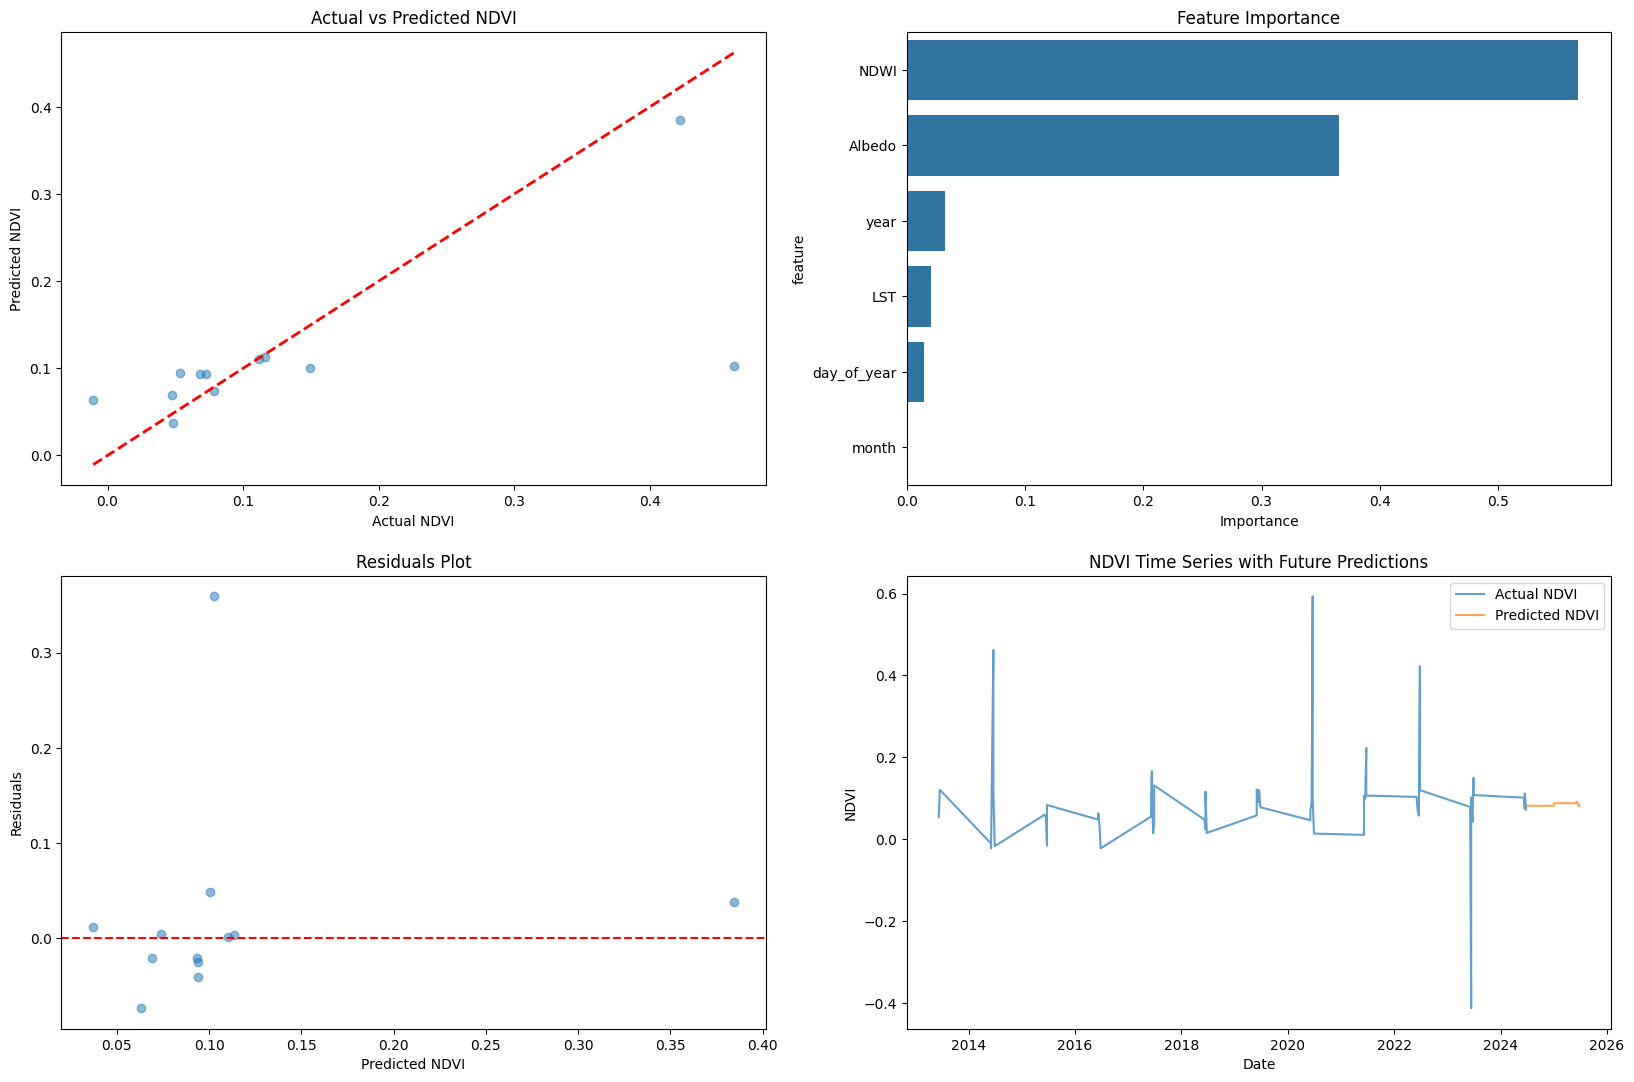

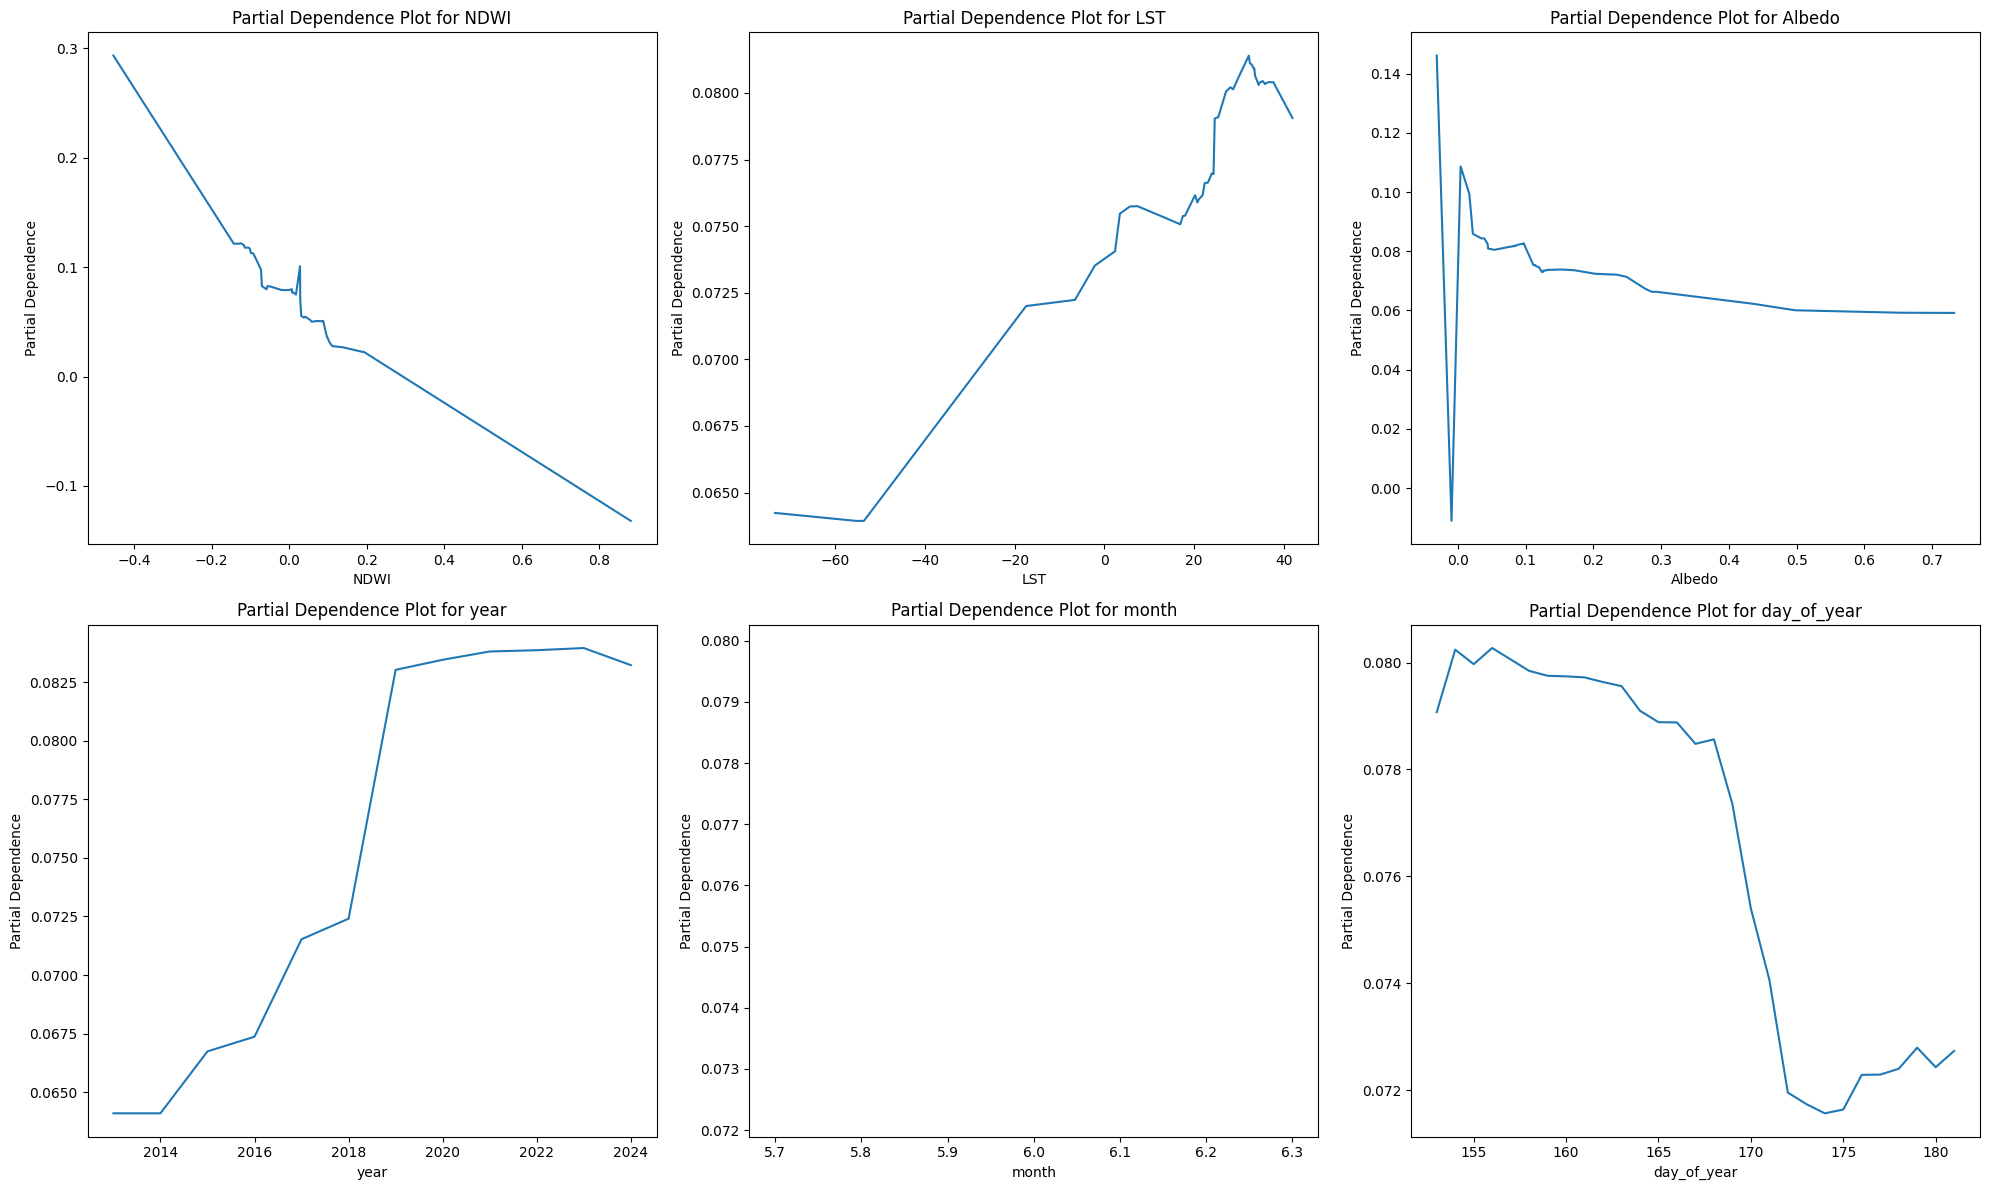

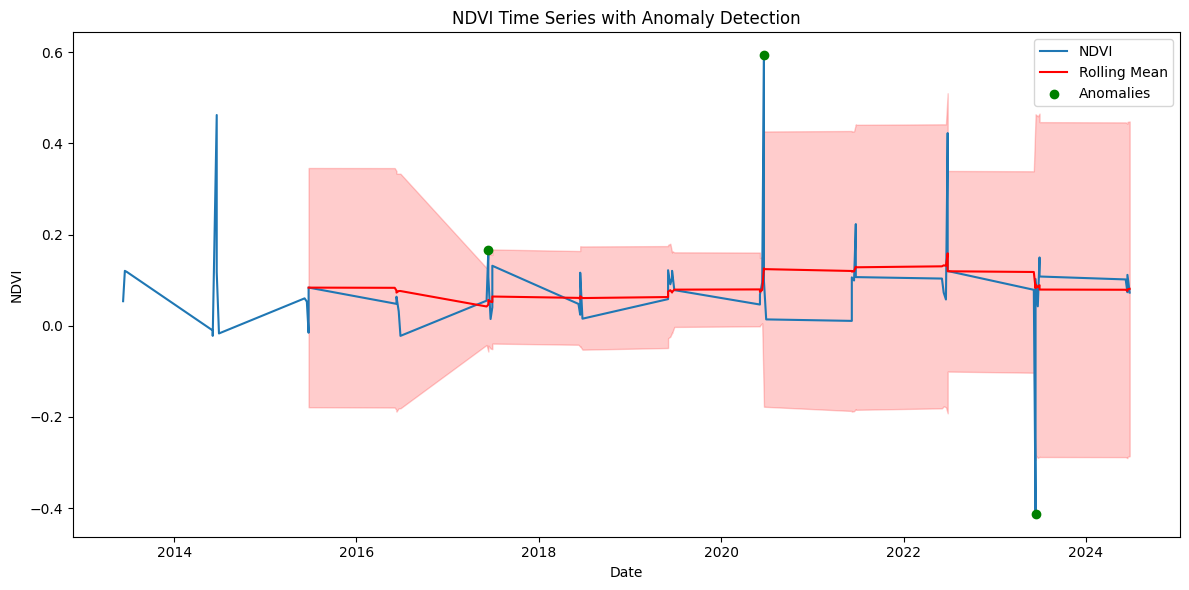

In [25]:
ml_analysis_results = perform_advanced_ml_analysis(l8_collection, aoi)

LSTM Model

In [28]:
def create_lstm_model(n_features, n_steps):
    inputs = Input(shape=(n_steps, n_features))
    lstm1 = LSTM(64, return_sequences=True)(inputs)
    lstm2 = LSTM(32, return_sequences=False)(lstm1)
    dense1 = Dense(16, activation='relu')(lstm2)
    outputs = Dense(n_features)(dense1)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

def prepare_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

def perform_robust_lstm_analysis(l8_collection, aoi):
    print("Performing robust LSTM analysis for environmental prediction...")

    try:
        # 1. Prepare the data
        def extract_features(image):
            features = image.select(['NDVI', 'NDWI', 'LST', 'TGSI', 'Albedo'])
            reduced = features.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=aoi,
                scale=30,
                maxPixels=1e9
            )
            return ee.Feature(None, reduced).set('date', image.date().millis())

        feature_collection = l8_collection.map(extract_features)
        data = pd.DataFrame([feat['properties'] for feat in feature_collection.getInfo()['features']])

        if data.empty:
            raise ValueError("No data extracted. check your image collection and area of interest.")

        data['date'] = pd.to_datetime(data['date'], unit='ms')
        data = data.set_index('date').sort_index()

        print("Data shape:", data.shape)
        print("Columns:", data.columns)
        print("Data types:")
        print(data.dtypes)
        print("\nSample data:")
        print(data.head())

        # 2. Normalize the data
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(data)

        # 3. Prepare sequences for LSTM
        n_steps = min(12, len(scaled_data) // 2)  # Adjust n_steps based on data availability
        X, y = prepare_sequences(scaled_data, n_steps)

        print("X shape:", X.shape)
        print("y shape:", y.shape)

        if len(X) < 10:
            raise ValueError(f"Not enough data for analysis. Only {len(X)} sequences created.")

        # 4. Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # 5. Create and train the model
        model = create_lstm_model(X.shape[2], n_steps)
        history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

        # 6. Make predictions
        y_pred = model.predict(X_test)

        # 7. Evaluate the model
        mse = np.mean((y_test - y_pred) ** 2, axis=1)
        print(f"\nMean Squared Error for each feature:")
        for i, feature in enumerate(data.columns):
            print(f"{feature}: {mse[i]}")

        # 8. Visualizations
        plt.figure(figsize=(20, 20))

        # 8.1 Training History
        plt.subplot(3, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Training History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # 8.2 Actual vs Predicted (for NDVI)
        plt.subplot(3, 2, 2)
        plt.scatter(y_test[:, 0], y_pred[:, 0], alpha=0.5)
        plt.plot([y_test[:, 0].min(), y_test[:, 0].max()], [y_test[:, 0].min(), y_test[:, 0].max()], 'r--', lw=2)
        plt.xlabel('Actual NDVI')
        plt.ylabel('Predicted NDVI')
        plt.title('Actual vs Predicted NDVI')

        # 8.3 Prediction Error Distribution
        plt.subplot(3, 2, 3)
        sns.boxplot(data=pd.DataFrame(y_test - y_pred, columns=data.columns))
        plt.title('Prediction Error Distribution by Feature')
        plt.ylabel('Error')
        plt.xticks(rotation=45)

        # 8.4 Time Series Forecast
        future_steps = min(24, len(X_test))
        last_sequence = X_test[-1]
        forecasts = []

        for _ in range(future_steps):
            forecast = model.predict(last_sequence.reshape(1, n_steps, -1))
            forecasts.append(forecast[0])
            last_sequence = np.roll(last_sequence, -1, axis=0)
            last_sequence[-1] = forecast

        forecasts = np.array(forecasts)
        forecasts = scaler.inverse_transform(forecasts)

        plt.subplot(3, 2, (4, 5))
        for i, feature in enumerate(data.columns):
            plt.plot(range(future_steps), forecasts[:, i], label=feature)
        plt.title('Multi-step Forecast for All Features')
        plt.xlabel('Future Time Steps')
        plt.ylabel('Predicted Values')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # 9. Feature Correlation Analysis
        plt.figure(figsize=(12, 10))
        correlation_matrix = data.corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
        plt.title('Feature Correlation Matrix')
        plt.show()

        return {
            'model': model,
            'mse': mse,
            'forecasts': forecasts,
            'correlation_matrix': correlation_matrix
        }

    except Exception as e:
        print(f"An error occurred during the LSTM analysis: {str(e)}")
        return None

print("LSTM analysis function defined")

LSTM analysis function defined


In [29]:
lstm_analysis_results = perform_robust_lstm_analysis(l8_collection, aoi)

Performing robust LSTM analysis for environmental prediction...
Data shape: (59, 5)
Columns: Index(['Albedo', 'LST', 'NDVI', 'NDWI', 'TGSI'], dtype='object')
Data types:
Albedo    float64
LST       float64
NDVI      float64
NDWI      float64
TGSI      float64
dtype: object

Sample data:
                           Albedo        LST      NDVI      NDWI      TGSI
date                                                                      
2013-06-10 07:21:17.178  0.077966  36.149441  0.053707  0.026618 -0.055723
2013-06-17 07:27:24.442  0.234223   7.406693  0.120293 -0.143123  0.046982
2013-06-26 07:21:12.992  0.171752  17.990534  0.117594 -0.117289 -0.039790
2014-06-04 07:24:41.417  0.344839 -40.337796 -0.010488  0.025570 -0.024981
2014-06-04 07:25:05.308  0.732477 -53.616643 -0.022332  0.030909 -0.024701
X shape: (47, 12, 5)
y shape: (47, 5)
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.3255 - val_loss: 0.3148
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.2967 -

KeyboardInterrupt: 

ML System

In [30]:
#ML System
import ee
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap, TimestampedGeoJson
import geopandas as gpd
from shapely.geometry import Point
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from scipy.stats import pearsonr
import warnings

warnings.filterwarnings('ignore')

class AdvancedEnvironmentalMLSystem:
    def __init__(self, l8_collection, aoi):
        self.l8_collection = l8_collection
        self.aoi = aoi
        self.data = None
        self.model = None
        self.scaler = MinMaxScaler()
        self.rf_model = None
        self.sarima_models = {}
        self.imputer = SimpleImputer(strategy='mean')

    def extract_features(self):
        def extract_image_features(image):
            indices = image.select(['NDVI', 'NDWI', 'LST', 'TGSI', 'Albedo'])
            reduced = indices.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=self.aoi,
                scale=30,
                maxPixels=1e9
            )
            return ee.Feature(None, reduced).set('date', image.date().millis())

        feature_collection = self.l8_collection.map(extract_image_features)
        data = pd.DataFrame([feat['properties'] for feat in feature_collection.getInfo()['features']])
        data['date'] = pd.to_datetime(data['date'], unit='ms')
        data = data.set_index('date').sort_index()

        # Add derived features
        data['NDVI_change'] = data['NDVI'].diff()
        data['LST_anomaly'] = data['LST'] - data['LST'].rolling(window=12).mean()
        data['season'] = data.index.month.map({12:1, 1:1, 2:1, 3:2, 4:2, 5:2, 6:3, 7:3, 8:3, 9:4, 10:4, 11:4})

        self.data = data

    def preprocess_data(self):
        # Impute missing values
        imputed_data = self.imputer.fit_transform(self.data)
        self.data = pd.DataFrame(imputed_data, columns=self.data.columns, index=self.data.index)

    def prepare_sequences(self, n_steps):
        scaled_data = self.scaler.fit_transform(self.data)
        X, y = [], []
        for i in range(len(scaled_data) - n_steps):
            X.append(scaled_data[i:i+n_steps])
            y.append(scaled_data[i+n_steps])
        return np.array(X), np.array(y)

    def build_hybrid_model(self, n_features, n_steps):
        # CNN-LSTM branch
        cnn_lstm_input = Input(shape=(n_steps, n_features))
        conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn_lstm_input)
        pool1 = MaxPooling1D(pool_size=2)(conv1)
        conv2 = Conv1D(filters=128, kernel_size=3, activation='relu')(pool1)
        pool2 = MaxPooling1D(pool_size=2)(conv2)
        lstm1 = LSTM(100, return_sequences=True)(pool2)
        lstm2 = LSTM(50)(lstm1)

        # Dense branch for additional features
        dense_input = Input(shape=(n_features,))
        dense1 = Dense(64, activation='relu')(dense_input)
        dense2 = Dense(32, activation='relu')(dense1)

        # Merge branches
        merged = Concatenate()([lstm2, dense2])
        output = Dense(n_features)(merged)

        model = Model(inputs=[cnn_lstm_input, dense_input], outputs=output)
        model.compile(optimizer='adam', loss='mse')
        return model

    def train_models(self):
        n_steps = min(12, len(self.data) // 2)
        X, y = self.prepare_sequences(n_steps)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Hybrid Deep Learning Model
        self.model = self.build_hybrid_model(X.shape[2], n_steps)
        self.model.fit([X_train, X_train[:, -1, :]], y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

        # Random Forest for feature importance
        self.rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        self.rf_model.fit(self.data, self.data['NDVI'])

        # SARIMA models for each feature
        for column in self.data.columns:
            try:
                model = SARIMAX(self.data[column], order=(1,1,1), seasonal_order=(1,1,1,12))
                results = model.fit()
                self.sarima_models[column] = results
            except:
                print(f"Could not fit SARIMA model for {column}")



    def make_predictions(self, future_steps=24):
        last_sequence = self.scaler.transform(self.data.iloc[-12:])
        forecasts = []

        for _ in range(future_steps):
            cnn_lstm_input = last_sequence.reshape(1, 12, -1)
            dense_input = last_sequence[-1].reshape(1, -1)
            forecast = self.model.predict([cnn_lstm_input, dense_input])
            forecasts.append(forecast[0])
            last_sequence = np.roll(last_sequence, -1, axis=0)
            last_sequence[-1] = forecast

        forecasts = np.array(forecasts)
        return self.scaler.inverse_transform(forecasts)

    def analyze_feature_importance(self):
        importance = self.rf_model.feature_importances_
        feature_importance = pd.DataFrame({'feature': self.data.columns, 'importance': importance})
        return feature_importance.sort_values('importance', ascending=False)

    def perform_trend_analysis(self):
        trends = {}
        for column in self.data.columns:
            x = np.arange(len(self.data))
            y = self.data[column].values
            r_value, p_value = pearsonr(x, y)
            slope, _ = np.polyfit(x, y, 1)
            trends[column] = {'slope': slope, 'r_value': r_value, 'p_value': p_value}
        return pd.DataFrame(trends).T

    def create_interactive_dashboard(self):
        forecasts = self.make_predictions()
        feature_importance = self.analyze_feature_importance()
        trends = self.perform_trend_analysis()

        # Create a Plotly dashboard
        fig = make_subplots(
            rows=3, cols=2,
            subplot_titles=('Time Series and Forecasts', 'Feature Importance',
                            'Trend Analysis', 'Feature Correlations',
                            'NDVI vs LST', 'Seasonal Patterns'),
            specs=[[{'type': 'scatter'}, {'type': 'bar'}],
                   [{'type': 'heatmap'}, {'type': 'heatmap'}],
                   [{'type': 'scatter'}, {'type': 'box'}]]
        )

        # Time Series and Forecasts
        for i, column in enumerate(self.data.columns):
            fig.add_trace(go.Scatter(x=self.data.index, y=self.data[column], name=column), row=1, col=1)
            fig.add_trace(go.Scatter(x=pd.date_range(start=self.data.index[-1], periods=25)[1:],
                                     y=forecasts[:, i], name=f'{column} Forecast', line=dict(dash='dash')), row=1, col=1)

        # Feature Importance
        fig.add_trace(go.Bar(x=feature_importance['feature'], y=feature_importance['importance'], name='Importance'), row=1, col=2)

        # Trend Analysis
        fig.add_trace(go.Heatmap(z=trends[['slope', 'r_value', 'p_value']].values,
                                 x=['Slope', 'R-value', 'P-value'],
                                 y=trends.index,
                                 colorscale='RdBu'), row=2, col=1)

        # Feature Correlations
        fig.add_trace(go.Heatmap(z=self.data.corr().values,
                                 x=self.data.columns,
                                 y=self.data.columns,
                                 colorscale='Viridis'), row=2, col=2)

        # NDVI vs LST
        fig.add_trace(go.Scatter(x=self.data['LST'], y=self.data['NDVI'], mode='markers', name='NDVI vs LST'), row=3, col=1)

        # Seasonal Patterns
        seasons = ['Winter', 'Spring', 'Summer', 'Fall']
        for i, feature in enumerate(['NDVI', 'LST', 'TGSI']):
            seasonal_data = [self.data[self.data['season'] == i+1][feature] for i in range(4)]
            fig.add_trace(go.Box(y=seasonal_data[0], name=f'{feature} - Winter', marker_color='skyblue'), row=3, col=2)
            fig.add_trace(go.Box(y=seasonal_data[1], name=f'{feature} - Spring', marker_color='lightgreen'), row=3, col=2)
            fig.add_trace(go.Box(y=seasonal_data[2], name=f'{feature} - Summer', marker_color='orange'), row=3, col=2)
            fig.add_trace(go.Box(y=seasonal_data[3], name=f'{feature} - Fall', marker_color='brown'), row=3, col=2)

        fig.update_layout(height=1200, width=1600, title_text="Advanced Environmental Analysis Dashboard")
        fig.show()

    def generate_recommendations(self):
        trends = self.perform_trend_analysis()
        forecasts = self.make_predictions()

        recommendations = []

        # Check for significant NDVI decline
        if trends.loc['NDVI', 'slope'] < -0.01 and trends.loc['NDVI', 'p_value'] < 0.05:
            recommendations.append("Significant vegetation decline detected. Consider implementing reforestation or land restoration projects.")

        # Check for increasing temperatures
        if trends.loc['LST', 'slope'] > 0.1 and trends.loc['LST', 'p_value'] < 0.05:
            recommendations.append("Rising temperature trend observed. Implement urban greening initiatives and heat mitigation strategies.")

        # Check for water stress
        if trends.loc['NDWI', 'slope'] < -0.005 and trends.loc['NDWI', 'p_value'] < 0.05:
            recommendations.append("Decreasing water availability detected. Consider implementing water conservation measures and drought-resistant vegetation.")

        # Analyze future predictions
        future_ndvi = forecasts[-1, self.data.columns.get_loc('NDVI')]
        if future_ndvi < self.data['NDVI'].mean():
            recommendations.append("Forecasted NDVI is below historical average. Intensify vegetation monitoring and consider preemptive conservation measures.")



        return recommendations

    def run_analysis(self):
        print("Extracting features...")
        self.extract_features()

        print("Preprocessing data...")
        self.preprocess_data()

        print("Training models...")
        self.train_models()

        print("Creating interactive dashboard...")
        self.create_interactive_dashboard()

        print("Generating recommendations...")
        recommendations = self.generate_recommendations()
        for i, rec in enumerate(recommendations, 1):
            print(f"{i}. {rec}")


print("Advanced Environmental ML System defined")

Advanced Environmental ML System defined


In [31]:
# Usage
ml_system = AdvancedEnvironmentalMLSystem(l8_collection, aoi)
ml_system.run_analysis()

Extracting features...
Preprocessing data...
Training models...
Creating interactive dashboard...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

Generating recommendations...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1. Rising temperature trend observed. Implement urban gree

In [32]:
import ee
import geemap
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed
import folium
from folium import plugins
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta


class AdvancedGeospatialMLSystem:
    def __init__(self, region_of_interest):
        self.roi = region_of_interest
        self.landsat_collection = None
        self.dem = None
        self.population = None
        self.climate_data = None
        self.lulc_data = None
        self.rf_model = None
        self.lstm_model = None

    def initialize_ee(self):
        ee.Initialize()


    def load_data(self, start_date, end_date):
        # Load Landsat 8 collection
        self.landsat_collection = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                                   .filterBounds(self.roi)
                                   .filterDate(start_date, end_date))

        # Load DEM data
        self.dem = ee.Image('USGS/SRTMGL1_003').clip(self.roi)

        # Try to load population data, use a placeholder if not available
        try:
            self.population = ee.ImageCollection("CIESIN/GPWv411/GPW_Population_Count").first().clip(self.roi)
        except:
            print("Population data not available. Using placeholder.")
            self.population = ee.Image.constant(1).rename('population').clip(self.roi)

        # Load climate data
        self.climate_data = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY").filterDate(start_date, end_date).select(['total_precipitation', 'temperature_2m']).mean().clip(self.roi)

        # Load LULC data
        self.lulc_data = ee.ImageCollection("ESA/WorldCover/v100").first().clip(self.roi)

    def extract_features(self, start_date, end_date):
        start = ee.Date(start_date)
        end = ee.Date(end_date)

        def process_interval(start_date, end_date):
            interval_collection = (self.landsat_collection
                                   .filterDate(start_date, end_date)
                                   .map(self.calculate_indices)
                                   .select(['NDVI', 'NDWI', 'TGSI', 'ST_B10']))

            combined = (interval_collection
                        .mean()
                        .addBands(self.dem.select(['elevation']))
                        .addBands(self.population)
                        .addBands(self.climate_data)
                        .addBands(self.lulc_data))

            return combined.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=self.roi,
                scale=30,
                maxPixels=1e9
            )

        interval = 30
        dates = pd.date_range(start_date, end_date, freq=f'{interval}D')
        features = []

        for i in range(len(dates) - 1):
            chunk_start = dates[i].strftime('%Y-%m-%d')
            chunk_end = dates[i + 1].strftime('%Y-%m-%d')
            chunk_features = process_interval(chunk_start, chunk_end).getInfo()
            chunk_features['start_date'] = chunk_start
            chunk_features['end_date'] = chunk_end
            features.append(chunk_features)

        return features
    def calculate_indices(self, image):
        ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
        ndwi = image.normalizedDifference(['SR_B3', 'SR_B5']).rename('NDWI')
        TGSI = image.expression(
            '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
            {
                'NIR': image.select('SR_B5'),
                'RED': image.select('SR_B4'),
                'BLUE': image.select('SR_B2')
            }
        ).rename('TGSI')
        return image.addBands([ndvi, ndwi, TGSI])
    def prepare_data(self, features):
        df = pd.DataFrame(features)
        df['datetime'] = pd.to_datetime(df['start_date']) + (pd.to_datetime(df['end_date']) - pd.to_datetime(df['start_date'])) / 2

        # Handle missing columns
        required_columns = ['NDVI', 'NDWI', 'TGSI', 'ST_B10', 'elevation', 'population', 'total_precipitation', 'temperature_2m', 'classification']
        for col in required_columns:
            if col not in df.columns:
                print(f"Warning: {col} not found in data. Using placeholder values.")
                df[col] = np.nan

        return df.sort_values('datetime')

    def train_rf_classifier(self, X, y):
        # Remove rows with NaN values
        valid_data = X.dropna()
        valid_labels = y[valid_data.index]

        if len(valid_data) < 10:
            print("Not enough valid data for Random Forest classification. Skipping.")
            return

        X_train, X_test, y_train, y_test = train_test_split(valid_data, valid_labels, test_size=0.2, random_state=42)
        self.rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
        self.rf_model.fit(X_train, y_train)
        y_pred = self.rf_model.predict(X_test)
        print(classification_report(y_test, y_pred))

    def train_lstm_model(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        self.lstm_model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
            TimeDistributed(Dense(1))
        ])
        self.lstm_model.compile(optimizer='adam', loss='mse')
        self.lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


    def create_interactive_map(self, df):
        center = self.roi.centroid().getInfo()['coordinates']
        map_center = center[::-1]  # Reverse coordinates for Folium
        m = folium.Map(location=map_center, zoom_start=10)

        # Add LULC layer
        lulc_palette = ['#006400', '#ffbb22', '#ffff4c', '#f096ff', '#fa0000', '#b4b4b4', '#f0f0f0', '#0064c8', '#0096a0', '#00cf75', '#fae6a0']
        lulc_vis_params = {'min': 0, 'max': 95, 'palette': lulc_palette}

        # Create the LULC layer using Earth Engine
        lulc_mapid = self.lulc_data.getMapId(lulc_vis_params)
        folium.TileLayer(
            tiles=lulc_mapid['tile_fetcher'].url_format,
            attr='Google Earth Engine',
            name='Land Use/Land Cover',
            overlay=True,
            control=True
        ).add_to(m)

        # Add NDVI time series as a heatmap
        if 'NDVI' in df.columns and 'longitude' in df.columns and 'latitude' in df.columns:
            ndvi_data = df[['longitude', 'latitude', 'datetime', 'NDVI']].dropna().values.tolist()
            if ndvi_data:
                folium.plugins.HeatMapWithTime(
                    ndvi_data,
                    index=2,
                    auto_play=True,
                    max_opacity=0.9,
                    radius=10,
                    name='NDVI Time Series'
                ).add_to(m)

        # Add layer control
        folium.LayerControl().add_to(m)

        return m

    def create_plotly_dashboard(self, df):
        fig = make_subplots(rows=2, cols=2, subplot_titles=('NDVI Time Series', 'LULC Distribution', 'Temperature vs NDVI', 'Elevation vs NDVI'))

        # NDVI Time Series
        fig.add_trace(go.Scatter(x=df['datetime'], y=df['NDVI'], mode='lines'), row=1, col=1)

        # LULC Distribution
        lulc_counts = df['classification'].value_counts()
        fig.add_trace(go.Bar(x=lulc_counts.index, y=lulc_counts.values), row=1, col=2)

        # Temperature vs NDVI
        fig.add_trace(go.Scatter(x=df['temperature_2m'], y=df['NDVI'], mode='markers'), row=2, col=1)

        # Elevation vs NDVI
        fig.add_trace(go.Scatter(x=df['elevation'], y=df['NDVI'], mode='markers'), row=2, col=2)

        fig.update_layout(height=800, width=1000, title_text="Environmental Analysis Dashboard")
        return fig



    def run_analysis(self, start_date, end_date):
        print("Initializing Earth Engine...")
        self.initialize_ee()

        print("Loading data...")
        self.load_data(start_date, end_date)

        print("Extracting features...")
        features = self.extract_features(start_date, end_date)
        df = self.prepare_data(features)

        print("Training Random Forest Classifier...")
        X = df[['NDVI', 'NDWI', 'TGSI', 'ST_B10', 'elevation', 'population', 'total_precipitation', 'temperature_2m']]
        y = df['classification']
        self.train_rf_classifier(X, y)

        print("Training LSTM Model...")
        X_lstm = df[['NDVI', 'NDWI', 'TGSI', 'ST_B10']].values.reshape(-1, 4, 4)
        y_lstm = df['NDVI'].values.reshape(-1, 4, 1)
        self.train_lstm_model(X_lstm, y_lstm)

        print("Creating interactive map...")
        interactive_map = self.create_interactive_map(df)
        interactive_map.save('interactive_map.html')
        print("Interactive map saved as 'interactive_map.html'")

        print("Creating Plotly dashboard...")
        dashboard = self.create_plotly_dashboard(df)
        dashboard.show()

        print("Analysis complete!")



print("Advanced Geospatial ML System for Environmental Monitoring defined. ")

Advanced Geospatial ML System for Environmental Monitoring defined. 


In [33]:
# Usage
roi = aoi
analysis_system = AdvancedGeospatialMLSystem(roi)
analysis_system.run_analysis('2020-01-01', '2021-12-31')

Initializing Earth Engine...
Loading data...
Extracting features...
Training Random Forest Classifier...
Not enough valid data for Random Forest classification. Skipping.
Training LSTM Model...
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: nan - val_loss: nan
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - loss: nan - val_loss: nan
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: nan - val_loss: nan
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: nan - val_loss: nan
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: nan - val_loss: nan
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: nan - val_loss: nan
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: nan - val_loss: nan
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: nan - val_loss: nan
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: nan - val_loss: nan
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: nan - val_loss: nan
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━

Analysis complete!


In [ ]:
import ee
import numpy as np
import pandas as pd
import folium
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

class SpectralChangeDetectionSystem:
    def __init__(self, roi):
        self.roi = roi
        ee.Initialize()

    def load_landsat_collection(self, start_date, end_date):
        return (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                .filterBounds(self.roi)
                .filterDate(start_date, end_date)
                .map(lambda img: img.clip(self.roi)))

    def spectral_unmixing(self, image):
        endmembers = [
            [0.0986, 0.0795, 0.0608, 0.1052, 0.2030, 0.1682],  # Vegetation
            [0.1350, 0.1250, 0.1150, 0.2250, 0.2550, 0.2200],  # Soil
            [0.0500, 0.0800, 0.1200, 0.0800, 0.0300, 0.0100]   # Water
        ]

        unmixed = image.select(['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']) \
            .unmix(endmembers)

        return image.addBands(unmixed.rename(['veg', 'soil', 'water']))

    def calculate_change_vector(self, start_image, end_image):
        diff = end_image.subtract(start_image)
        magnitude = diff.expression(
            'sqrt(veg*veg + soil*soil + water*water)',
            {'veg': diff.select('veg'),
             'soil': diff.select('soil'),
             'water': diff.select('water')}
        ).rename('change_magnitude')

        direction = diff.expression(
            'atan2(water, sqrt(veg*veg + soil*soil))',
            {'veg': diff.select('veg'),
             'soil': diff.select('soil'),
             'water': diff.select('water')}
        ).rename('change_direction')

        return magnitude.addBands(direction)

    def run_analysis(self, start_date, end_date):
        collection = self.load_landsat_collection(start_date, end_date)

        start_image = self.spectral_unmixing(collection.first())
        end_image = self.spectral_unmixing(collection.sort('system:time_start', False).first())

        change_vector = self.calculate_change_vector(start_image, end_image)

        return change_vector

    def visualize_results(self, change_vector):
        # Create an interactive map
        center = self.roi.centroid().getInfo()['coordinates']
        m = folium.Map(location=[center[1], center[0]], zoom_start=10)

        # Add change magnitude layer
        magnitude_vis = {'min': 0, 'max': 0.5, 'palette': ['blue', 'yellow', 'red']}
        magnitude_mapid = change_vector.select('change_magnitude').getMapId(magnitude_vis)
        folium.TileLayer(
            tiles=magnitude_mapid['tile_fetcher'].url_format,
            attr='Google Earth Engine',
            name='Change Magnitude',
            overlay=True,
            control=True
        ).add_to(m)

        # Add change direction layer
        direction_vis = {'min': -np.pi, 'max': np.pi, 'palette': ['green', 'yellow', 'blue']}
        direction_mapid = change_vector.select('change_direction').getMapId(direction_vis)
        folium.TileLayer(
            tiles=direction_mapid['tile_fetcher'].url_format,
            attr='Google Earth Engine',
            name='Change Direction',
            overlay=True,
            control=True
        ).add_to(m)

        folium.LayerControl().add_to(m)

        # Save the map
        m.save('change_vector_map.html')
        print("Interactive map saved as 'change_vector_map.html'")

        # Create change vector plot
        samples = change_vector.sample(region=self.roi, scale=30, numPixels=5000).getInfo()
        df = pd.DataFrame(samples['features'])

        magnitude = df['properties'].apply(lambda x: x['change_magnitude'])
        direction = df['properties'].apply(lambda x: x['change_direction'])

        fig = make_subplots(rows=1, cols=2, subplot_titles=('Change Vector Plot', 'Change Magnitude Distribution'))

        # Change Vector Plot
        fig.add_trace(
            go.Scatter(
                x=magnitude * np.cos(direction),
                y=magnitude * np.sin(direction),
                mode='markers',
                marker=dict(
                    size=5,
                    color=magnitude,
                    colorscale='Viridis',
                    showscale=True
                ),
                name='Change Vectors'
            ),
            row=1, col=1
        )

        # Change Magnitude Distribution
        kde = gaussian_kde(magnitude)
        x_range = np.linspace(magnitude.min(), magnitude.max(), 100)
        fig.add_trace(
            go.Scatter(
                x=x_range,
                y=kde(x_range),
                mode='lines',
                fill='tozeroy',
                name='Magnitude Distribution'
            ),
            row=1, col=2
        )

        fig.update_layout(height=600, width=1200, title_text="Change Vector Analysis Results")
        fig.show()

    def run_and_visualize(self, start_date, end_date):
        print("Running analysis...")
        change_vector = self.run_analysis(start_date, end_date)

        print("Visualizing results...")
        self.visualize_results(change_vector)

        print("Analysis and visualization complete!")



print("Spectral Unmixing and Change Vector Analysis System defined. ")

In [ ]:
# Usage

change_detection = SpectralChangeDetectionSystem(aoi)
change_detection.run_and_visualize('2020-01-01', '2021-12-31')